<div class="alert alert-block alert-info">

<center><h1>My version of this notebook of the ECMWF MOOC</h1></center>
  <p style="margin-bottom:1.5cm;"> </p>
  
<center><font size="8"><strong>SOLUTIONS</strong></font></center>
<p style="margin-bottom:1cm;"> </p>

<font size=5>My codes to solve the proposed exercices are [here](SOL_obs-env.ipynb#improving_decision_tree_regressor), [there](SOL_obs-env.ipynb#handling_missing_values) and [there](SOL_obs-env.ipynb#NBEATS).</font>

The original notebook provided in the context of the ECMWF MOOC on machine learning in weather and climate begins below.

</div>

Welcome to this notebook! If you're new to Python, don't worry, this notebook is designed to help you get familiar with some concepts of Machine Learning. You can simply run the script to see how it works. On the other hand, if you're familiar with Python, feel free to change the parameters to better understand how it works.

Whether you're a beginner or an experienced user, we hope you find this notebook informative and helpful.

# Setup

## - Working locally 
If you're running this notebook locally, you might need to create a proper conda environment using the file "environment.yml":
- conda env create -f environment.yml (the first line of the yml file sets the new environment's name.)
- conda activate myenv (the environment's name)
- conda install -c anaconda ipykernel
- python -m ipykernl install --user --name=myenv

Using the above command, you will have the appropriate conda environment in your Jupyter notebook.
![kernel](adding_conda_kernel.jpeg)

Change the kernel to be your new environement: 'mooc_ntbk' if you kept the default name.
Please consider running the cell below to handle some version conflicts.

In [1]:
#--------------------------------------# 
# Fix python path of working locally   #
#--------------------------------------#
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
path = './data/'

## - Running the tutorial via free cloud platforms


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/obs-env.ipynb)

First, let's install and import some useful libraries/modules. 

In [3]:
#--------------------------#
# Install some libraries   #
#--------------------------#
!pip install openturns darts matplotlib==3.6.3

# MATPLOTLIB VERSION NEEDS TO BE 3.6.3

In [4]:
#--------------------------#
# Check matplotlib version #
#--------------------------#
import matplotlib
matplotlib.__version__

'3.6.3'

If at this stage the matplotlib version is not 3.6.3, go to 'Runtime' and press 'restart runtime' and execute again the cell above. 

In [5]:
#-----------------------------# 
# Import external libraries   #
#-----------------------------#
import os
import sys

import numpy as np 
import pandas as pd

import openturns as ot
from openturns.viewer import View

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

from darts.utils.statistics import check_seasonality, plot_acf, TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, ExponentialSmoothing, Prophet, RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [12, 7]

import datetime, time

import logging
logging.disable(logging.CRITICAL)
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [6]:
#----------------------# 
# Download data        #
#----------------------#
!wget https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/raw/main/tier_3/observations/data.zip

--2023-05-09 12:33:08--  https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/raw/main/tier_3/observations/data.zip
Résolution de github.com (github.com)… 140.82.121.3
Connexion à github.com (github.com)|140.82.121.3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://raw.githubusercontent.com/ecmwf-projects/mooc-machine-learning-weather-climate/main/tier_3/observations/data.zip [suivant]
--2023-05-09 12:33:08--  https://raw.githubusercontent.com/ecmwf-projects/mooc-machine-learning-weather-climate/main/tier_3/observations/data.zip
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 597527 (584K) [application/zip]
Enregistre : «data.zip»

data.zip            100%[===================>] 583,5

In [7]:
# Unzip the data
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: data/dis_obs_clim.csv   
  inflating: data/y_train.npy        
  inflating: data/y_test.npy         
  inflating: data/x_test.npy         
  inflating: data/x_train.npy        
  inflating: data/hydrograph.txt     


# 1) Generating perturbations to account for uncertainties in discharge observations

All observations have some degree of uncertainty associated with them, whether it be due to measurement errors, variability in the system being observed, or other factors. By quantifying this uncertainty we can account for the limitations of the data and to appropriately interpret the results of our analysis. It also helps to identify areas where further data collection or analysis may be needed to reduce uncertainty and improve the reliability of our conclusions.

## a. Discharge observation data
Discharge observations during a flood event can be obtained through various methods including:

- Stream gauges: Physical instruments installed along rivers or streams that measure the flow of water.

- Remote sensing: Use of satellite imagery and other aerial technologies to estimate discharge from above.

- Numerical models: Predictive simulations that use historical data and real-time weather data to estimate discharge.

- Field measurements: Direct measurement of water flow velocity and cross-sectional area to estimate discharge.

In [8]:
path = './data/'

Text(0.5, 1.0, 'Hydrograph in the upstream station \n of a catchment during a flood event')

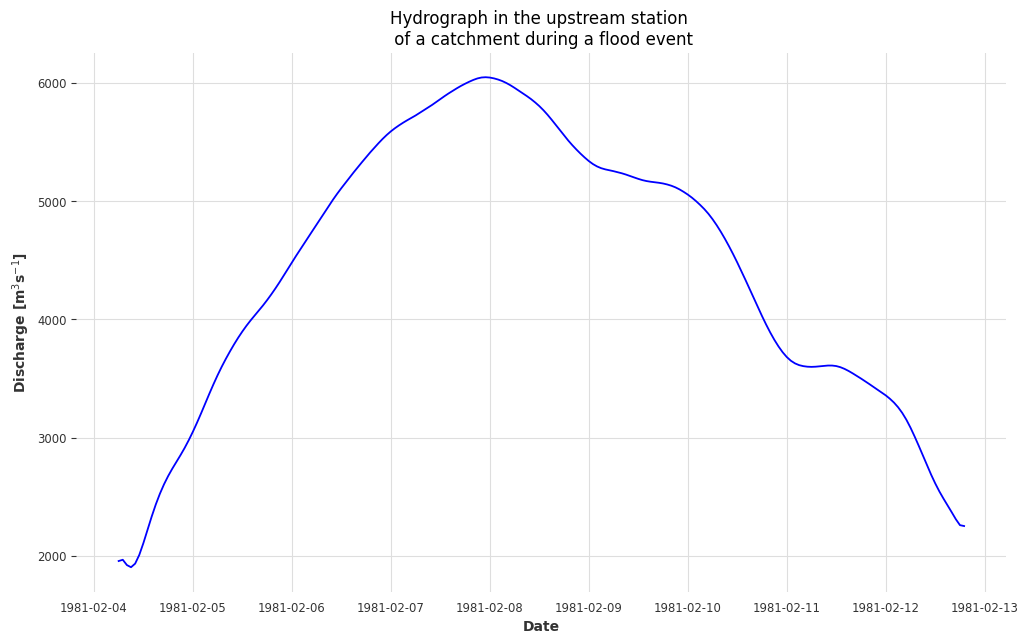

In [9]:
#--------------------------------#
# Read data                      #
#--------------------------------#
# Read a hydrograph of a flood event of ~8 days. The data is hourly
filename = 'hydrograph.txt'
n_skipLine = 1 
qt = ot.Sample.ImportFromTextFile(os.path.join(path, filename), ' ', n_skipLine)
t = qt.getMarginal(0) #time in sec, ref date is 04/02/1981 at 6:00am
q = qt.getMarginal(1)

tdate = pd.date_range(start='2/4/1981 6H', periods=len(qt), freq='H')

plt.plot(tdate, q, color='blue')
plt.xlabel("Date")
plt.ylabel("Discharge [m$^3$s$^{-1}$]")
plt.title('Hydrograph in the upstream station \n of a catchment during a flood event')

Discharge observations are uncertain due to several factors, including:

- Measurement error: Discharge measurements can be affected by measurement error, such as the accuracy of the measurement device or the presence of debris in the river that can block the device. This can result in readings that are higher or lower than the actual discharge.

- Channel changes: Changes to the river channel, such as sediment deposition or erosion, can alter the relationship between stage (water level) and discharge. This can result in discharge observations that are not accurate or reliable.

- Inadequate data: In some cases, discharge observations may not be available for all periods of interest, or the data may be sparse or of low quality. This can result in significant uncertainty in the discharge observations.

- Interpolation and extrapolation: In some cases, discharge observations may need to be interpolated or extrapolated to estimate discharge at ungauged locations or over longer periods of time. This can result in additional uncertainty in the discharge observations.

These are just a few examples of why discharge observations can be uncertain. It is important to understand the sources of uncertainty in discharge observations and to use appropriate methods to account for this uncertainty when analyzing and using discharge data. In our case, we will consider ensemble methods by perturbing the hydrograph to account for uncertainties.

## b. Discharge perturbations

To create realistic perturbations, we use the covariance to model the relationship between discharge at different timesteps.

The covariance model of a time series is a statistical model that describes the dependence structure of the series over time. In particular, the covariance model specifies the relationship between the mean and variance of the series as well as the correlation between observations at different points in time. The covariance between two observations at times $t$ and $s$ is defined as:

$Cov(X_t, X_s) = E[(X_t - μ_t)(X_s - μ_s)]$

where $X_t$ and $X_s$ are the values of the time series at times $t$ and $s$, $μ_t$ and $μ_s$ are the means of the time series at times $t$ and $s$, and $E$ is the expected value operator.

The covariance model of a time series assumes that the time series is stationary, meaning that its statistical properties do not change over time. Under this assumption, the covariance between two observations only depends on the time lag between them, and not on the specific time points at which they occur. In other words, the covariance between $X_t$ and $X_s$ only depends on the time difference $|t-s|$.

E20230509 12:33:10.328859 38420 trust_region_minimizer.cc:95] Terminating: Number of consecutive invalid steps more than Solver::Options::max_num_consecutive_invalid_steps: 5
WRN - Switch to finite difference to compute the gradient at point=[818248,-25.8623,-0.000135101]
WRN - TNC went to an abnormal point x=[nan,nan,nan] y=[] msg=TNC got a nan input value


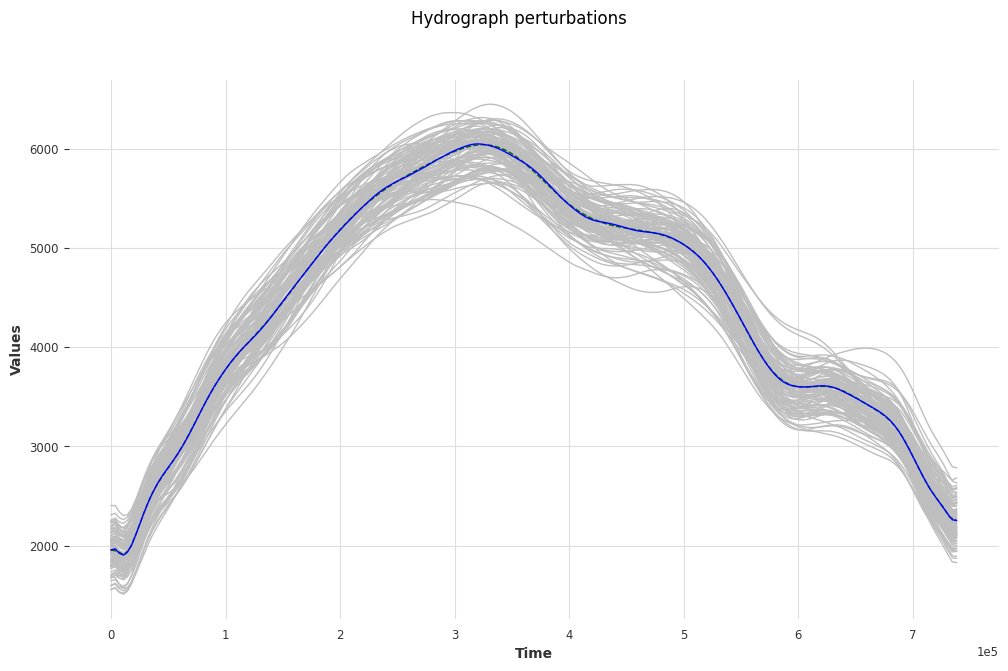

In [10]:
#-----------------------------------------#
# Define the temporal grid accoring to    # 
# the timesteps defined in the hydrograph #
#-----------------------------------------#
myTimeGrid = ot.RegularGrid(np.min(t), t[1, 0] - t[0, 0], t.getSize())
graph = myTimeGrid.draw()
graph.setTitle("Regular temporal grid")
view = ot.viewer.View(graph)

#----------------------------------------------------------------#
# Identify the time series with a Polynomial Chaos Expansion     #
#----------------------------------------------------------------#
max_poly_degree = 25
ot.ResourceMap.SetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree", max_poly_degree)
algo = ot.FunctionalChaosAlgorithm(t, q)
algo.run()
trend = algo.getResult().getMetaModel()

#-------------------------------------------------------#
# Calibrate the covariance model using expert knowledge #
#-------------------------------------------------------# 
# The Matern covariance function is commonly used as a kernel function in a Gaussian Process.
amplitude = [200] # We assume that, on average, the difference of discharge between two observations is 200 m3/s
scale = [86400] # We assume that the correlation length is of 1 day
nu = 5/2
covarianceModel = ot.MaternModel(scale, amplitude, nu)

#------------------------------------------------------------------#
# Create a Gaussian process to get realizations past the last time #
#------------------------------------------------------------------#
process = ot.GaussianProcess(ot.TrendTransform(trend, myTimeGrid), covarianceModel, myTimeGrid)
nb = 100 # number of desired perturbations
sample = process.getSample(nb)
g = sample.drawMarginal(0)
g.setColors(["gray"]) # Perturbations are plotted in solid gray lines
c = trend.draw(myTimeGrid.getVertices()[0], myTimeGrid.getVertices()[-1]).getDrawable(0) 
c.setLineStyle("dashed") 
c.setColor("darkgreen") # Polynomial model is plotted in dashed green line
g.add(c)
g.add(ot.Curve(t,q)) # Observed discharge in blue
g.setTitle("Hydrograph perturbations")
ot.Show(g)

- Perturbations were generated using a Gaussian process model. 
- To construct a Gaussian process model, we need to specify the mean and and the covariance of the process.
- Polynomial Chaos expansion model was used to fit the observed discharge. Its mean/trend was considered to be the mean of the Gaussian process.
- The covariance of the Gaussian process, in our case, was constructed based on the hydrologist judgement. 

###  <div class="alert-danger"> Q1) How does the hydrograph perturbation change according to: Amplitude? Scale? Maximum polynomial degree? </div>  

# 2) Predictive model of the water level at a station given the Strickler coefficient at this station and the discharge at the upstream area

Now, let's build a surrogate model that predicts the water level timeseries in a station in the middle of the catchment given the Strickler coefficient in this station and the discharge in the upstream station at a given timestep. The Strickler coefficient reflects the roughness of the bottom of the river at a given location. 

The size of the input training data is 1,000 members. They are derived from a perturbation procedure similar to the one described above. The input data contain the upstream discharge (x_train[:,0]) and the Strickler coefficient (x_train[:,1]). The different outputs of the hydrodynamic model are grouped in the output training data and describe a timeseries (52 timesteps) of the water height at a station located in the middle of the catchment.

The size of the test file is 500 members. The test file and the training file were constructed independently. 

In [11]:
#------------------#
# Upload data      #
#-----------------# 
### Training data
x_train = np.load(os.path.join(path, 'x_train.npy'))
y_train = np.load(os.path.join(path, 'y_train.npy'))

### Test data
x_test = np.load(os.path.join(path, 'x_test.npy'))
y_test = np.load(os.path.join(path, 'y_test.npy'))

print("The size of the training sample is: {:d}".format(x_train.shape[0]))
print("The size of the test sample is: {:d}".format(x_test.shape[0]))
print("Number of features is: {:d}".format(x_train.shape[1]))

The size of the training sample is: 1000
The size of the test sample is: 500
Number of features is: 2


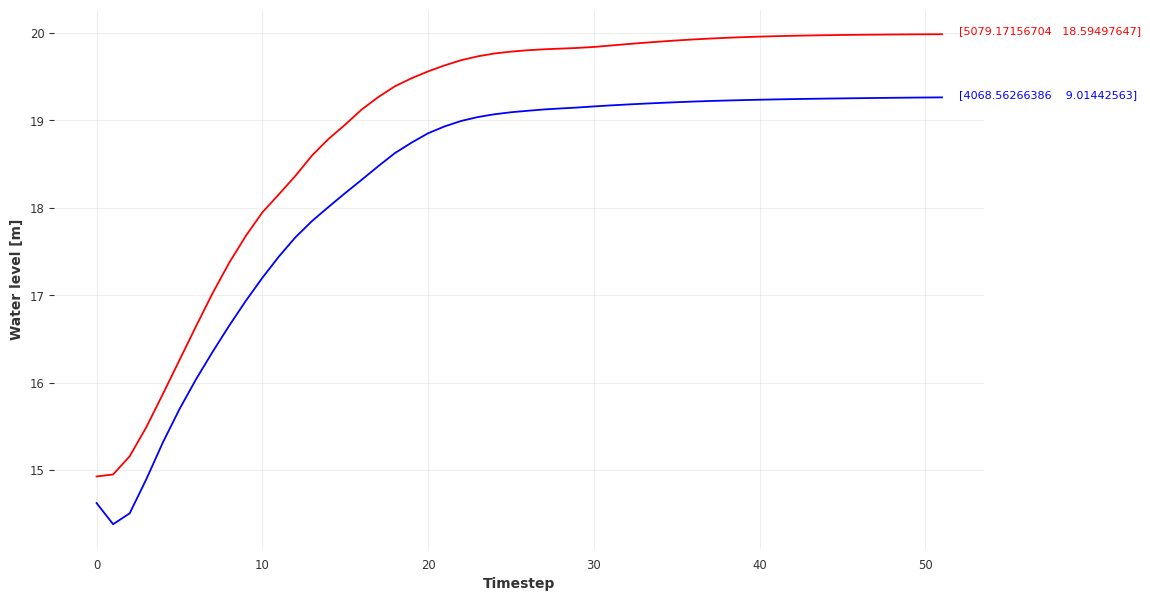

In [12]:
#------------------#
# Visualise data   #
#------------------# 
### Before diving into constructing the surrogate model, one necessary step is: Data visualisation

# plot the max and min of the simulation according to the last timestep
simu_max = np.argmax((y_train[:][-1]))
plt.plot(y_train[simu_max], c='red')
plt.text(y_train.shape[1], y_train[simu_max][-1], x_train[simu_max], fontsize=8, c='red') 

simu_min = np.argmin((y_train[:][-1]))
plt.plot(y_train[simu_min], c='blue')
plt.text(y_train.shape[1], y_train[simu_min][-1], x_train[simu_min], fontsize=8, c='blue') 

plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Water level [m]')
plt.grid(alpha=0.5)
plt.show()

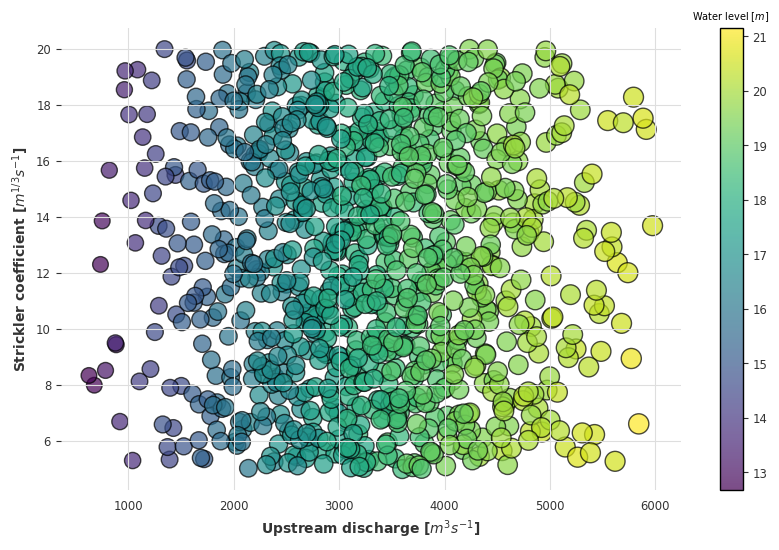

In [13]:
# plot changes in the water level in the last timestep accriding to the discharge and the Strickler coefficient
x = x_train[:,0]
y = x_train[:,1]

timestep = -1 # last time step 
z = y_train[:,timestep]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = z*10,
           c=z)
plt.xlabel('Upstream discharge [$m^3s^{-1}$]')
plt.ylabel('Strickler coefficient [$m^{1/3}s^{-1}$]')

clb = plt.colorbar()
clb.ax.set_title('Water level [$m$]', fontsize=7)
plt.show()

Let's build a Decision Tree regressor model to mimic the behaviour of the hydrodynamic model to speed up this latter.

A Decision Tree Regressor is a supervised learning algorithm that is used for regression tasks. The algorithm builds a tree-like model of decisions and their possible consequences, where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a prediction for the target variable.

The Decision Tree algorithm works by recursively splitting the data into subsets based on the values of a selected attribute. The attribute with the highest predictive power is selected as the root node of the tree, and the data is split based on its values. The process is repeated for each subset until the leaf nodes are reached, where the prediction is made for the target variable.

The goal of the Decision Tree regressor is to minimize the variance of the target variable within each leaf node while maximizing the difference in the means between different leaf nodes. This is achieved by selecting the optimal split point for each node based on the variance reduction criterion, such as the mean squared error (MSE) or mean absolute error (MAE).

For more information, please check: https://scikit-learn.org/stable/modules/tree.html#tree

In [14]:
#------------------------------#
# Train a DecisionTree model   #
#------------------------------# 
### Constructing a surrogate model
rf = DecisionTreeRegressor()
training_start_time = time.process_time() #CPU time
rf_model = rf.fit(x_train, y_train)
print(f'CPU time for training is: {time.process_time() - training_start_time}')
test_start_time = time.process_time()
y_pred = rf_model.predict(x_test)
print(f'CPU time for test is: {time.process_time() - test_start_time}')
# If you want to measure wall clock time instead, use time.time()

### How good are the predictions?
q2_score = r2_score(y_pred, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("The R2 score on test set: {:.4f}".format(q2_score))
print("The root mean squared error (RMSE) on test set: {:.4f} [m]".format(rmse))

CPU time for training is: 0.01968250100000013
CPU time for test is: 0.0010086999999998625
The R2 score on test set: 0.8456
The root mean squared error (RMSE) on test set: 0.3055 [m]


In [15]:
#------------------------------------#
# Visualise the DecisionTree model   #
#------------------------------------# 
plot = False # Visualise the decision tree as plot; it takes time and the generated plot is not readable 
if plot:
    fig = plt.figure(figsize=(25,20)) 
    _ = tree.plot_tree(rf, filled=True)
text_representation = tree.export_text(rf) # Visualise the decision tree as text 
print(text_representation)

|--- feature_0 <= 2833.19
|   |--- feature_0 <= 1913.17
|   |   |--- feature_0 <= 1226.58
|   |   |   |--- feature_0 <= 900.83
|   |   |   |   |--- feature_0 <= 766.31
|   |   |   |   |   |--- feature_1 <= 13.08
|   |   |   |   |   |   |--- feature_0 <= 650.13
|   |   |   |   |   |   |   |--- value: [14.67, 14.38, 14.32, 14.42, 14.51, 14.53, 14.50, 14.44, 14.35, 14.25, 14.14, 14.02, 13.90, 13.77, 13.64, 13.51, 13.38, 13.24, 13.11, 12.99, 12.90, 12.83, 12.78, 12.75, 12.73, 12.72, 12.71, 12.71, 12.71, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70]
|   |   |   |   |   |   |--- feature_0 >  650.13
|   |   |   |   |   |   |   |--- feature_1 <= 10.15
|   |   |   |   |   |   |   |   |--- value: [14.70, 14.28, 14.14, 14.21, 14.29, 14.30, 14.27, 14.20, 14.12, 14.02, 13.92, 13.81, 13.70, 13.59, 13.47, 13.35, 13.23, 13.11, 12.99, 12.89, 12.81, 12.76, 12.73, 12.71, 12.69, 12.69, 12.68,

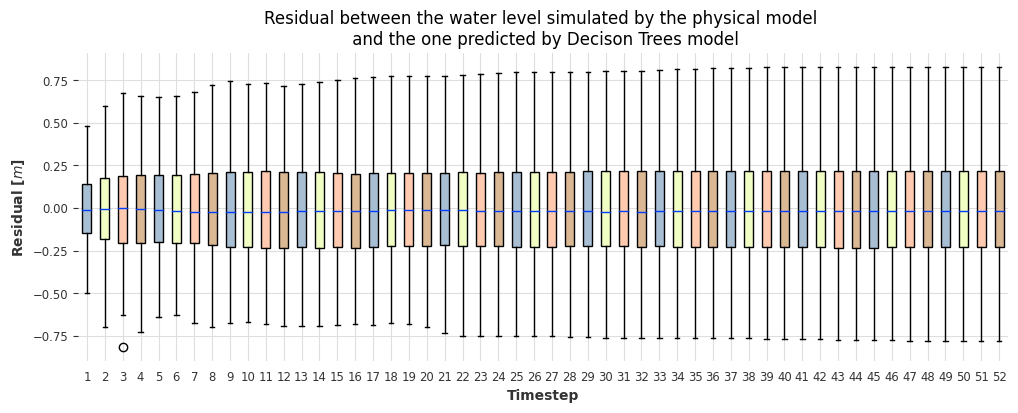

In [16]:
#--------------------#
# Plot the residual  #
#------------------––#
# Plot the difference between the water level in the test file and the one predicted by the ML model

residual = y_test - y_pred

# box plot
fig, ax = plt.subplots(figsize=(12, 4))
bplot = ax.boxplot(residual,
                     vert=True,  # vertical box alignment
                     patch_artist=True)  
colors = ['#a7bed3', '#f1ffc4', '#ffcaaf', '#dab894']*13
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Timestep')
plt.ylabel('Residual [$m$]')
plt.title('Residual between the water level simulated by the physical model \n and the one predicted by Decison Trees model')
plt.show()

### <div class="alert-danger">  Q2) Try to train another model on the dataset assuming that the RMSE should not exceed 30cm.  </div>  

# My code to improve the decision tree regressor <a class="anchor" id="improving_decision_tree_regressor"></a>

The above model is completely overfitted, since no restrictions were put on the decision tree. Indeed, if we give a lower bound on the number of samples in each leaf, the RMSE already improves. Setting to this value to 10 seems to be a good starting point.

Reusing some parts of the code above:

In [17]:
rf = DecisionTreeRegressor(min_samples_leaf = 10)
rf_model = rf.fit(x_train, y_train)

### How good are the predictions?
y_pred = rf_model.predict(x_test)
q2_score = r2_score(y_pred, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("The R2 score on test set: {:.4f}".format(q2_score))
print("The root mean squared error (RMSE) on test set: {:.4f} [m]".format(rmse))

The R2 score on test set: 0.8155
The root mean squared error (RMSE) on test set: 0.2380 [m]


One can also tune the maximum depth. A useful tool for tuning hyperparameter is <a href="https://www.ray.io/ray-tune">Ray Tune</a>. This library provides a tuner, taking as arguments a trainer function and a dict from which hyperparameters values are picked up.

In [18]:
from ray import air, tune
from ray.air import session

def DTRtrainer(config):
    rf = DecisionTreeRegressor(min_samples_leaf=config["min_samples_leaf"], max_depth=config["max_depth"])
    rf_model = rf.fit(x_train, y_train)
    
    y_pred = rf_model.predict(x_test)
    q2_score = r2_score(y_pred, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # report these metrics to tune
    session.report({
        "q2_score" : q2_score,
        "rmse" : rmse
    })
    
search_space = {
    "min_samples_leaf": tune.randint(2, 30),
    "max_depth": tune.randint(1, 20)
}

tuner = tune.Tuner(
    DTRtrainer,
    param_space = search_space,
    tune_config = tune.TuneConfig(num_samples=50) # number of decision trees to train
    )

results = tuner.fit()

df_results = results.get_dataframe() #results are collected in a dataframe

Here is the configuration with the least RMSE value.

In [19]:
df_results.iloc[df_results["rmse"].idxmin()]

q2_score                                                             0.446626
rmse                                                                 0.232207
time_this_iter_s                                                       0.0084
done                                                                    False
timesteps_total                                                           NaN
episodes_total                                                            NaN
training_iteration                                                          1
trial_id                                                          e9618_00033
experiment_id                                7bbeb5a56b404892963469ae30fff2db
date                                                      2023-05-09_12-33-28
timestamp                                                          1683628408
time_total_s                                                           0.0084
pid                                                             

The RMSE value is not substantially improved. The $R^2$ coefficient is worse than before tuning, but this coefficient loses much of its interpretability for nonlinear models.


# 3) Monthly flow climate data analysis 

In [20]:
#------------------------------------------------------------#
# Load the discharge historical data at a specific location  #
#------------------------------------------------------------#
df = pd.read_csv(os.path.join(path, 'dis_obs_clim.csv')) 
df['month'] = pd.to_datetime(df['month'])
df

month  dis_observed
0   2000-01-01     49.141290
1   2000-02-01     63.602069
2   2000-03-01     69.980645
3   2000-04-01     28.339000
4   2000-05-01     28.950323
..         ...           ...
259 2021-08-01     16.082581
260 2021-09-01     13.500000
261 2021-10-01     23.997742
262 2021-11-01     30.696333
263 2021-12-01     52.714194

[264 rows x 2 columns]

In [21]:
#------------------#
# Describe data    #
#------------------#
df.describe()

dis_observed
count    238.000000
mean      36.476164
std       22.756222
min       11.276897
25%       19.501917
50%       27.838613
75%       49.193226
max      116.681786

<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

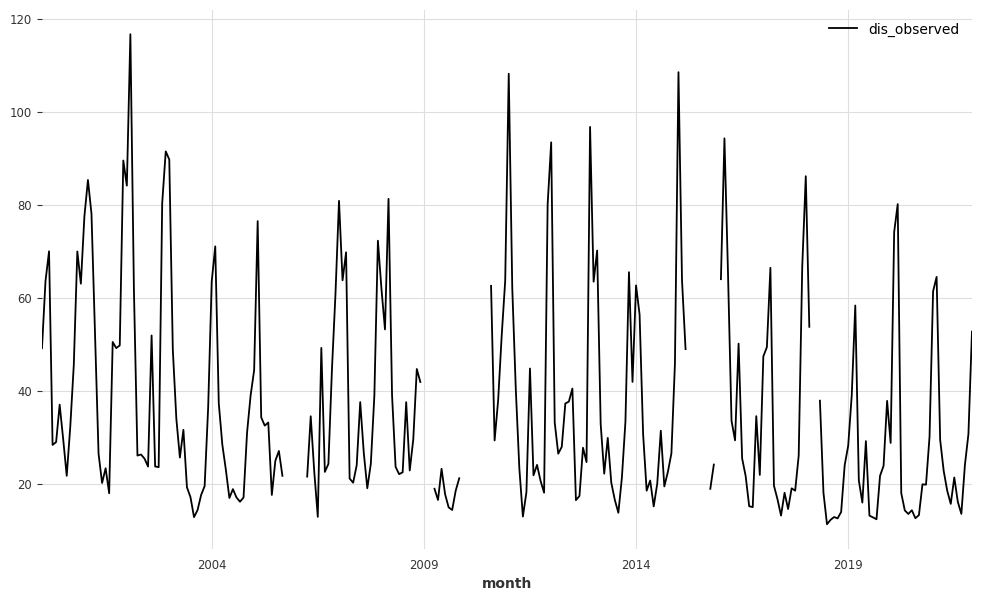

In [22]:
#------------#
# plot data  #
#------------#
plt.figure(100, figsize=(10,5))
df.plot(x='month', y='dis_observed', color = "black")

Handling missing values highly depends on the nature of the data, the size and location of the gaps, and the intended use of the data. In general, the main common strategies are: 
- Removing rows with missing values.
- Mark and learn missing values.
- Mask and learn without missing values.

Try each approach on your sequence prediction problem and double down on what appears to work best.
Here are some commonly used methods to fill gaps in a time series:

- Forward fill (or backward fill): This method fills the gap with the last (or first) observed value. This method is suitable when the missing values occur in sequences or when the data has a slowly changing trend.

- Linear interpolation: This method fills the gap with a straight line between the last observed value before the gap and the first observed value after the gap. This method is suitable when the data has a linear trend.

- Seasonal interpolation: This method fills the gap with a value that corresponds to the same season or time of day as the missing value. This method is suitable when the data has a seasonal pattern.

- Mean or median imputation: This method fills the gap with the mean or median of the observed values. This method is suitable when the data has a normal distribution.

- Regression imputation: This method uses regression models to predict the missing values based on the relationship between the time series and other relevant variables. This method is suitable when the data has complex patterns or when the gaps are large.

## a. Gap filling 
### a.1) Using Inverse Principal Component Analysis

Given a time series $X$ of length $n$, with $m$ missing values, IPCA aims to fill in the missing values by decomposing $X$ into its principal components and filling in the missing values in the principal component space. Let $X'$ be the filled-in time series, and let $P$ be the matrix of principal components. Then, IPCA can be expressed as:

$X' = P * diag(eigenvalues) * P^T$, 

where diag(eigenvalues) is a diagonal matrix of eigenvalues and $P^T$ is the transpose of $P$.

NB: $m$ should be small.

In [23]:
#-----------------------------------------#
# Compute the ratio of the missing values # 
#-----------------------------------------#
null_values = df['dis_observed'].isnull()
print('The ratio of missing values is: {:.2f} %'.format(round(sum(null_values)*100/len(df), 2)))

The ratio of missing values is: 9.85 %


In [24]:
#------------#
# Scale data #
#------------#
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(np.array(df['dis_observed']).reshape(-1,1))
df['dis_scaled'] = ts_scaled

<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

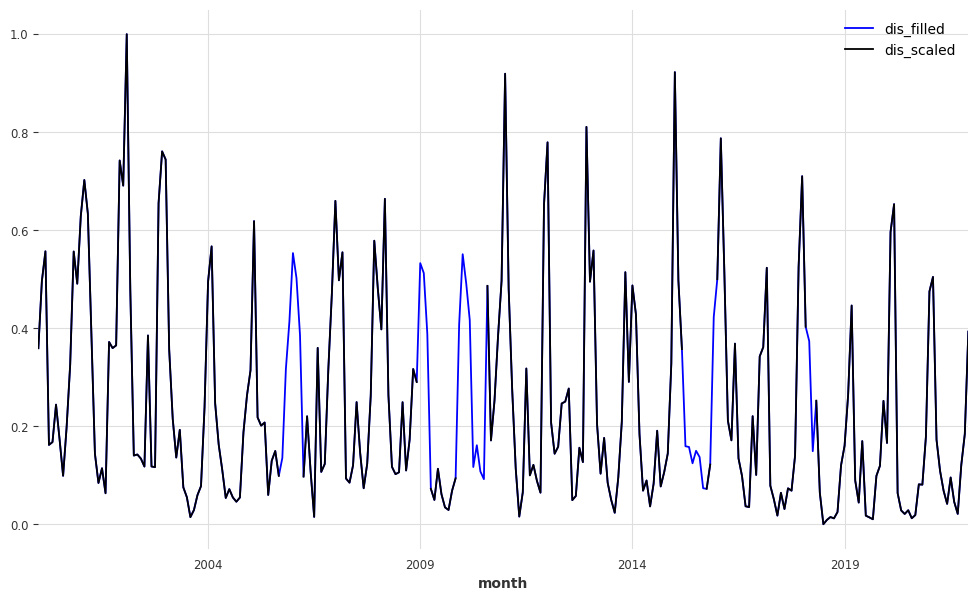

In [25]:
#-------------------------------------------#
# Impute missing values with PCA inverse    # 
#-------------------------------------------#
data_month = np.array(ts_scaled).reshape(-1, 12) # reshape data
data = np.where(np.isnan(data_month), np.ma.array(data_month, mask=np.isnan(data_month)).mean(axis=0), data_month) # imputation using the mean to get rid of NaN values so the PCA can be computed
pca = PCA(n_components=0.9)
data_filled = pca.inverse_transform(pca.fit_transform(data))
df['dis_pcai'] = list(data_filled.reshape(-1))
df['dis_filled'] = df['dis_scaled'].fillna(df['dis_pcai'])

### plot the PCA result
plt.figure(100, figsize=(10,5))
df.plot(x='month', y=['dis_filled', 'dis_scaled'], color = ["blue", "black"])

### a.2) Gap filling using Multivariate Imputation by Chained Equation

Multivariate Imputation by Chained Equation (MICE) first calculates the mean of every column where there is a missing value and uses the mean value as a placeholder. Then it runs a series of regression models (chained equations) to impute each missing value sequentially. Like in any regression model, MICE uses a feature matrix and target variable to train, and in this case, the target variable is the column with missing values. MICE predicts and updates missing values on target columns. Iteratively, MICE repeats this process several times by constantly changing the placeholder variables with the predictions from the previous iteration. In the end, it reaches a robust estimation.

In [26]:
#-------------------------------------------#
# Impute missing values with MICE           # 
#-------------------------------------------#
### Extract the month only (month_) to use it as a predictor for MICE
df['month_'] = [df['month'][x].month for x in range(len(df['month']))]


### Imputing with MICE
df_mice = df.filter(['month_','dis_scaled']).copy()


### Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

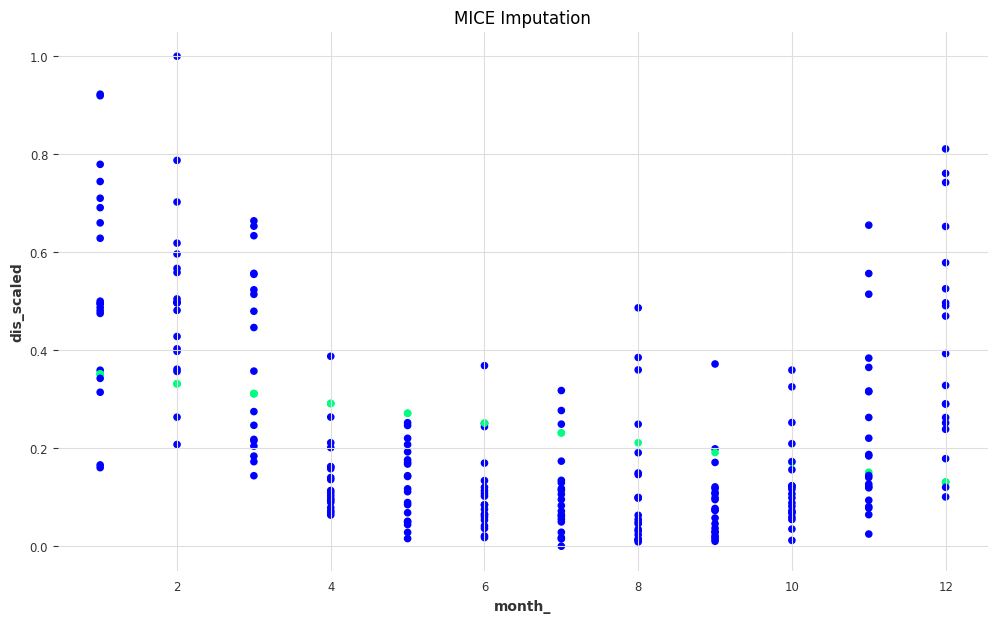

In [27]:
#-----------------#
#Plot MICE result # 
#-----------------#
fig = plt.Figure() 
fig = df_mice_imputed.plot(x='month_', y='dis_scaled', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

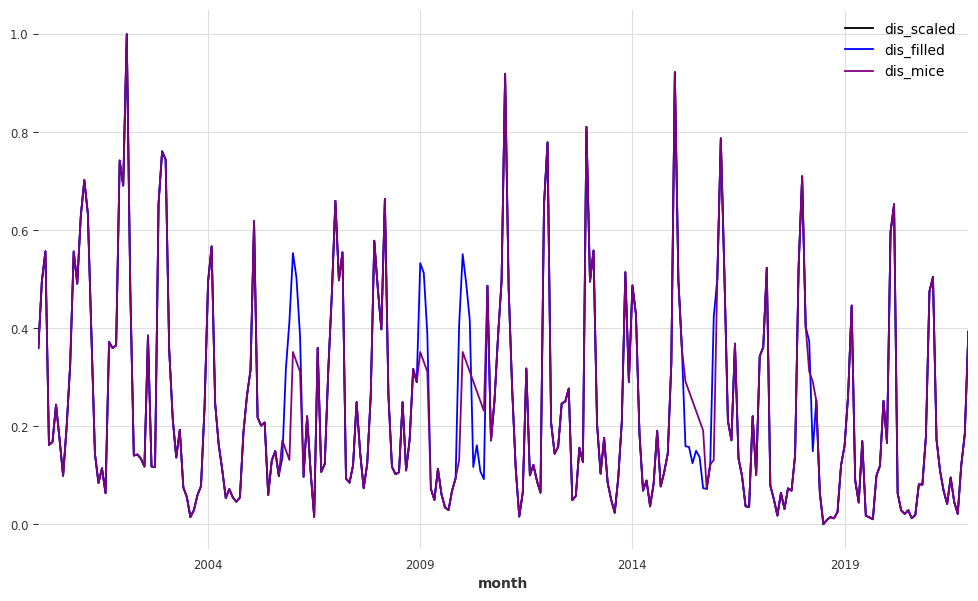

In [28]:
### Plot result as a time series
df['dis_mice'] = df_mice_imputed['dis_scaled']
plt.figure(100, figsize=(10,5))
df.plot(x='month', y=['dis_scaled', 'dis_filled', 'dis_mice'], color = ["black", "blue", "purple"])

In the following, we'll consider PCA inverse imputation.

## b. Time series forecasting

In [29]:
### analyze its seasonality
ts_scaled = TimeSeries.from_dataframe(df, 'month', 'dis_filled')
is_seasonal, periodicity = check_seasonality(ts_scaled, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


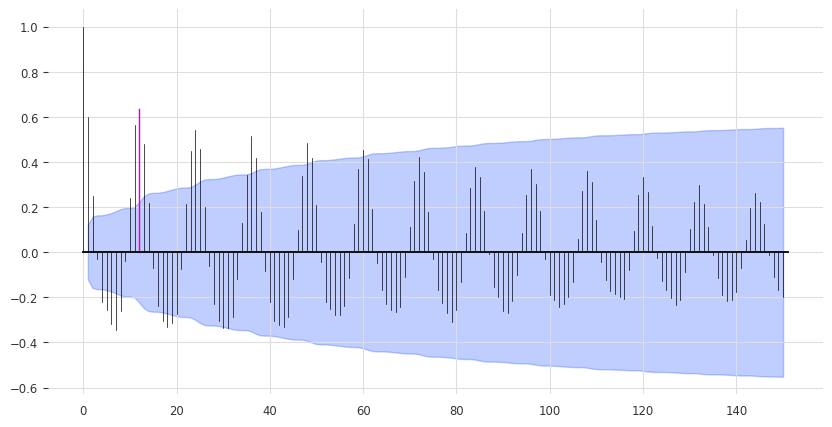

In [30]:
### plot its autocorrelation function
plot_acf(ts_scaled, periodicity, max_lag=150)

Neural Basis Expansion Analysis (NBEA) is a method for time series forecasting that combines neural networks with basis expansion techniques. The basic idea behind NBEA is to use a neural network to learn a mapping between the past values of a time series and its future values, while also using basis expansion techniques to capture non-linear relationships between the time series and its predictors.

NBEA works by first transforming the input time series into a basis-expanded representation, which captures non-linear relationships between the time series and its predictors. This basis-expanded representation is then used as input to a neural network, which learns a mapping between the past values of the time series and its future values. The output of the neural network is then transformed back into the original time series space.

The main advantage of NBEA is that it can capture complex non-linear relationships between the time series and its predictors, while also leveraging the power of neural networks for time series forecasting. NBEA has been shown to be effective for a wide range of time series forecasting tasks, including financial forecasting, environmental forecasting, and traffic forecasting.

In [31]:
#--------------------------------------------------#
# Forecast the last three years of the time series # 
# using NBEATS model                               #
#--------------------------------------------------#
### Split training vs test dataset
# Let's keep the last 36 months as test
ts_split = -36
train, test = ts_scaled[:ts_split], ts_scaled[ts_split:]

Let’s look at a first example. We’ll build an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so that our model will produce successive predictions for one year at a time, looking at the past two years.

In [32]:
### Define the model parameters
model = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=1
)

In [33]:
### Fit the model using the training data 
#--- for n_epochs=50, the training lasts ~2 minutes
nbeats_start_time = time.time()
model.fit(train, verbose=True)
print(f'Training duration time: {time.time() - nbeats_start_time}')

Training: 0it [00:00, ?it/s]

Training duration time: 57.42851424217224


We can then get a forecast by calling predict(). 

Note that below, we are calling predict() with a horizon of 36, which is longer than the model internal output_chunk_length of 12. That’s not a problem here, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

MAPE = 'Mean Absolute Percentage Error'

Predicting: 0it [00:00, ?it/s]

MAPE = 151.35%


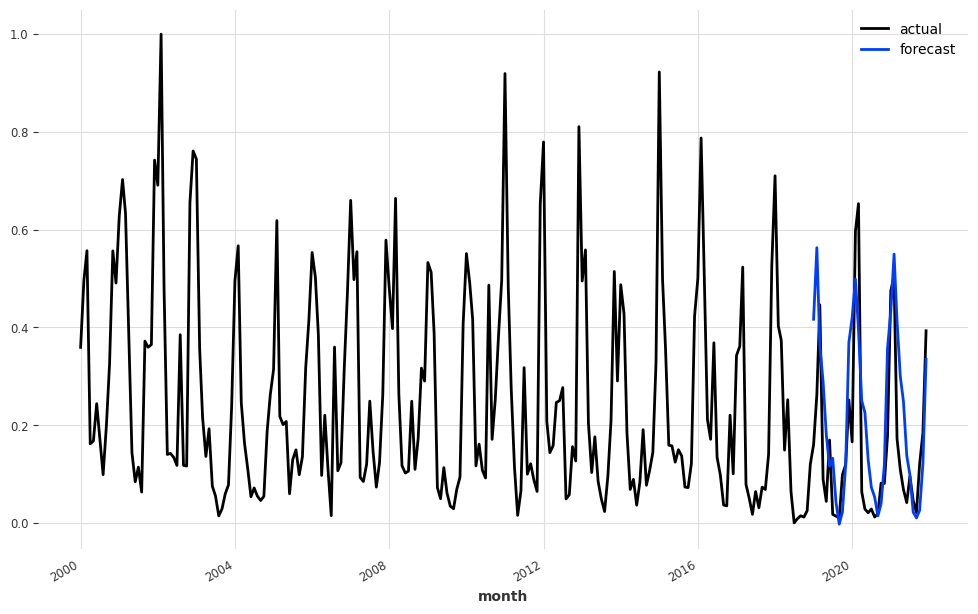

In [34]:
### Predict the test data 
pred = model.predict(n=36)
ts_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(ts_scaled, pred)))

Some options could be investigated to optimize the model:
- *Increase the number of epochs:* An epoch is one full pass through the training data, and increasing the number of epochs allows the model to see the training data more times and refine its weights accordingly. However, increasing the number of epochs beyond a certain point can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new data. Therefore, it's important to find the optimal number of epochs that balances between the underfitting and overfitting. This can be done by monitoring the validation loss while training the model and stopping the training when the validation loss starts to increase.

- *Increase the size of the model:* The NBEATSModel consists of several fully connected layers, and increasing the size of the model can help to increase its capacity and improve its performance. You can try adding more layers or increasing the number of units in each layer.

- *Adjust the learning rate:* The learning rate determines how much the weights of the model are updated during each iteration of training. If the learning rate is too high, the model may overshoot the optimal weights and fail to converge. If the learning rate is too low, the model may take a long time to converge. You can try adjusting the learning rate to find the optimal value.

- *Add regularization:* Regularization techniques such as L1 or L2 regularization, dropout, or early stopping can help to prevent overfitting and improve the generalization performance of the model. You can try adding one or more of these techniques to the model.

- *Use a different optimizer:* The optimizer is responsible for updating the weights of the model during training. Different optimizers have different strengths and weaknesses, and choosing the right optimizer can help to improve the performance of the model. You can try using a different optimizer, such as Adam or RMSprop, to see if it improves the performance.

- *Increase the amount of training data:* Deep learning models require a large amount of data to learn complex patterns effectively. If you have a small amount of training data, you can try augmenting the data by applying transformations such as rotation, translation, or scaling. This can help to increase the size of the training set and improve the performance of the model.

Now, we used Darts to obtain one forecast over the next 36 months starting in January 2019. However, forecasts often need to be updated as soon as new data becomes available. With Darts, it’s easy to compute the forecasts resulting from such a process, using backtesting. Backtesting refers to the process of evaluating the performance of a forecasting model on historical data.

- Prophet is a forecasting technique developed by Facebook that uses an additive model to decompose a time series into its underlying components such as trend, seasonality, holidays, and outliers. The model uses a Bayesian framework to estimate the parameters and can handle missing data and irregularly spaced time series.

- Exponential Smoothing is a family of forecasting methods that uses a weighted average of past observations to forecast future values. The weights assigned to past observations decay exponentially as the observations get older. 

In [35]:
### Backtesting 
models = [ExponentialSmoothing(), Prophet()]

backtests = [model.historical_forecasts(ts_scaled,
                            start=.8571, # the split is given as a percentage
                            forecast_horizon=3) # three months forecast horizon 
             for model in models]

The function historical_forecasts() takes a time series, a starting point (here, 85% of the time series) and a forecast horizon. It returns the TimeSeries containing the historical forecasts that would have been obtained when using the model to forecast the series with the specified forecast horizon (here 3 months), starting at the specified timestamp (using an expanding window strategy).

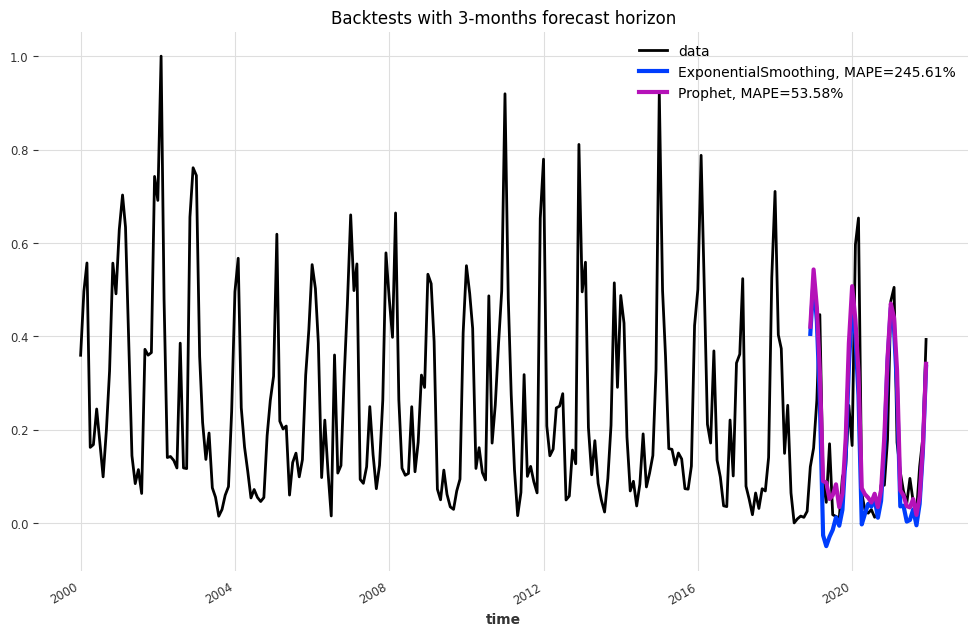

In [36]:
#--------------------------------------------------#
# Forecast the last three years of the time series # 
# using backtesting process                        #
#--------------------------------------------------#
models_str = ['ExponentialSmoothing', 'Prophet']
ts_scaled.plot(label='data')
for i, m in enumerate(models_str):
    err = mape(backtests[i], ts_scaled)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()

Backtesting forecasting models — here we simulate making forecasts with a 3 months horizon, every month starting in January 2019 (so the first forecast value is for April 2019).

### <div class="alert-danger">  Q3) Try to optimize these models using one of the different techniques listed above.  </div>  

# My code to handle the missing values <a class="anchor" id="handling_missing_values"></a>

We first try the different propositions to handle the missing values in the data. The NBEAST model is trained on each of these data sets, in order to see which yields the best result. We include the data produced with the MICE procedure.

We first create the columns of the <code>df</code> dataframe with the corresponding data (already scaled):

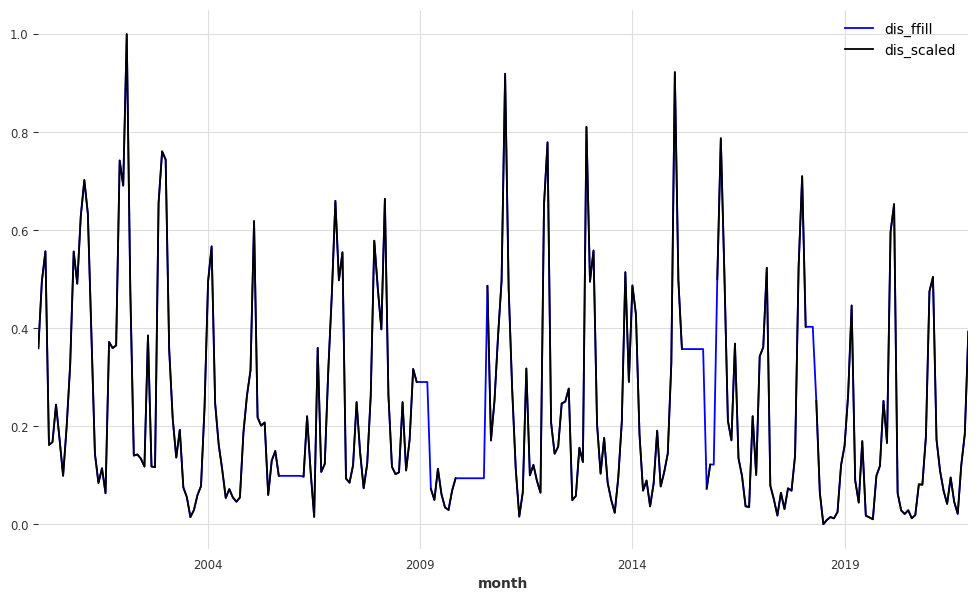

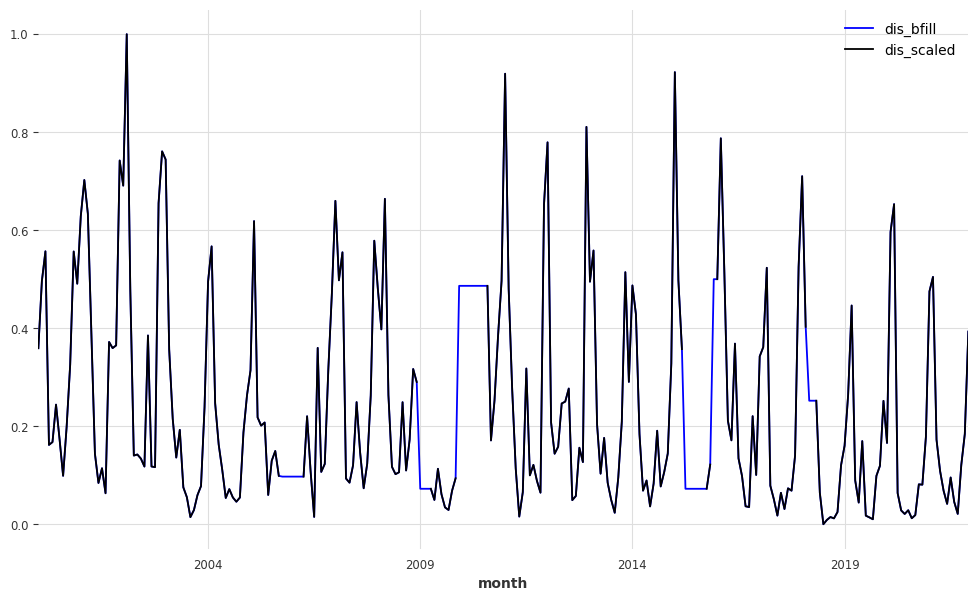

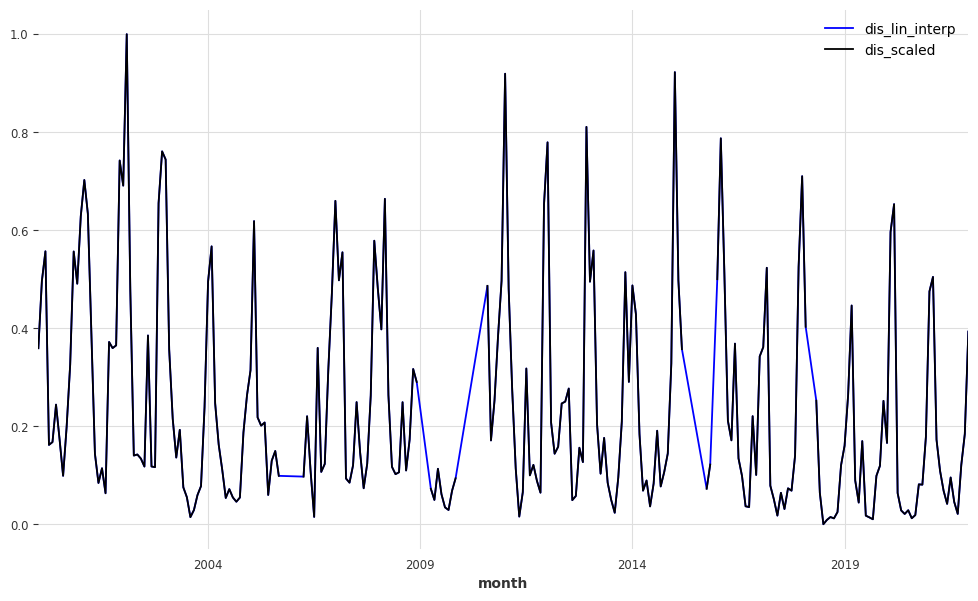

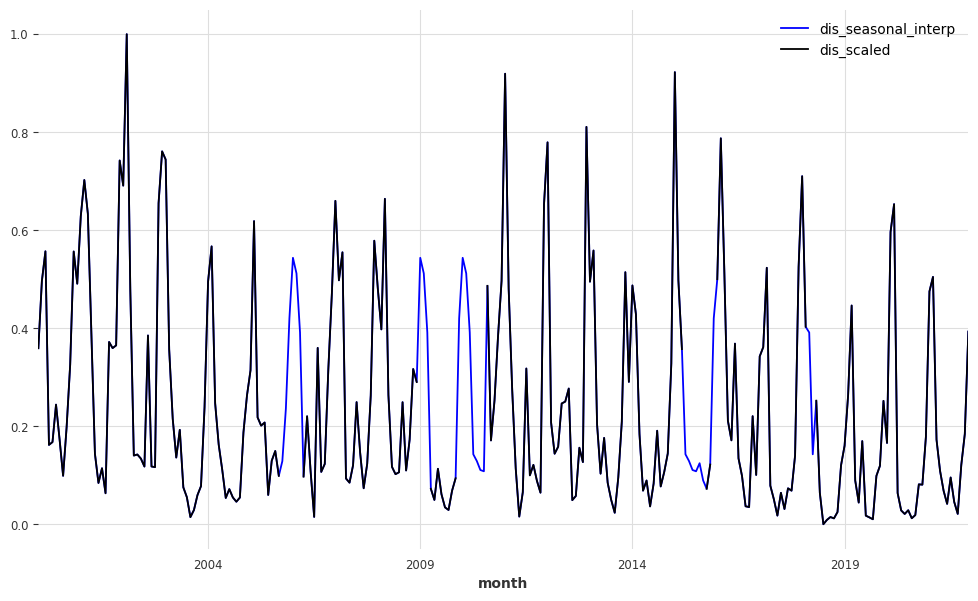

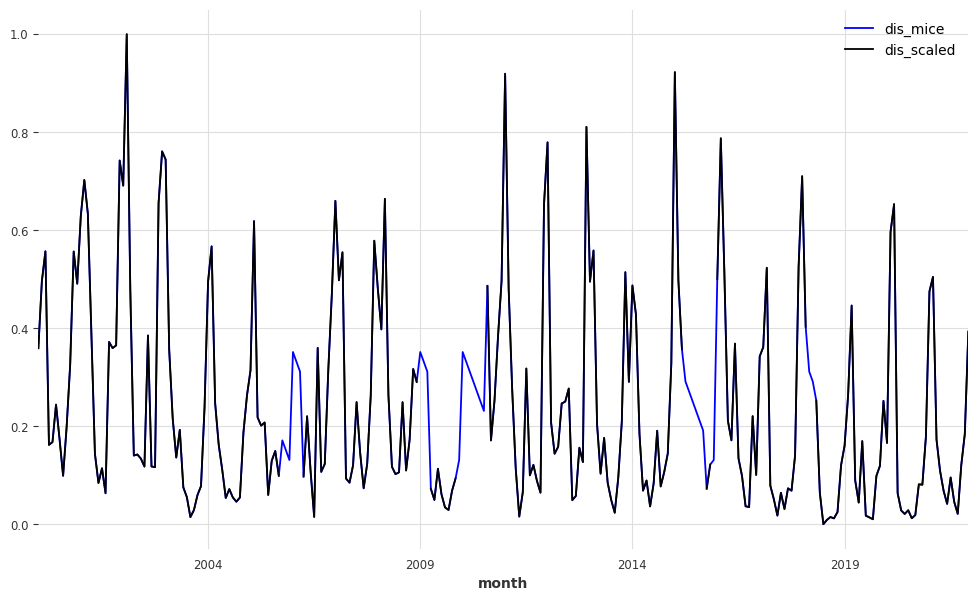

In [37]:
# forward fill
df['dis_ffill'] = df['dis_scaled'].fillna(method='ffill')
# backward fill
df['dis_bfill'] = df['dis_scaled'].fillna(method='bfill')
# linear interpolation
df['dis_lin_interp'] = df['dis_scaled'].interpolate(method='index')

# Seasonal interpolation: replace the value by the mean of values of the same month
monthly_means = df.groupby('month_').mean()
idx_missing_dis_scaled = df['dis_scaled'].isna()
df['dis_seasonal_interp'] = df['dis_scaled']
df['dis_seasonal_interp'][idx_missing_dis_scaled] = monthly_means['dis_scaled'][df['month_'][idx_missing_dis_scaled]]

fill_methods=['_ffill', '_bfill', '_lin_interp', '_seasonal_interp', '_mice']
for fill_method in fill_methods:
    df.plot(x='month', y=['dis'+fill_method, 'dis_scaled'], color = ["blue", "black"])
    plt.show()

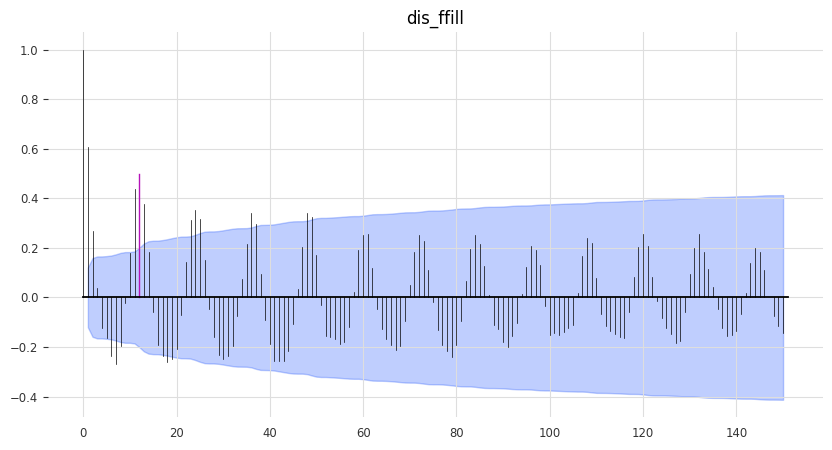

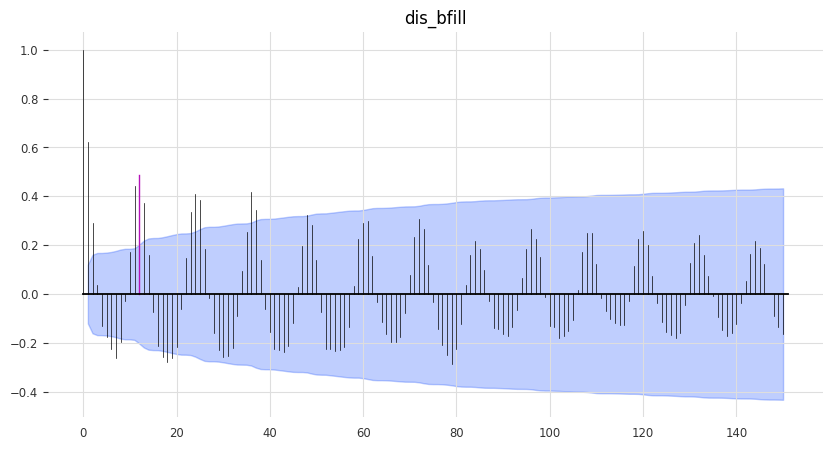

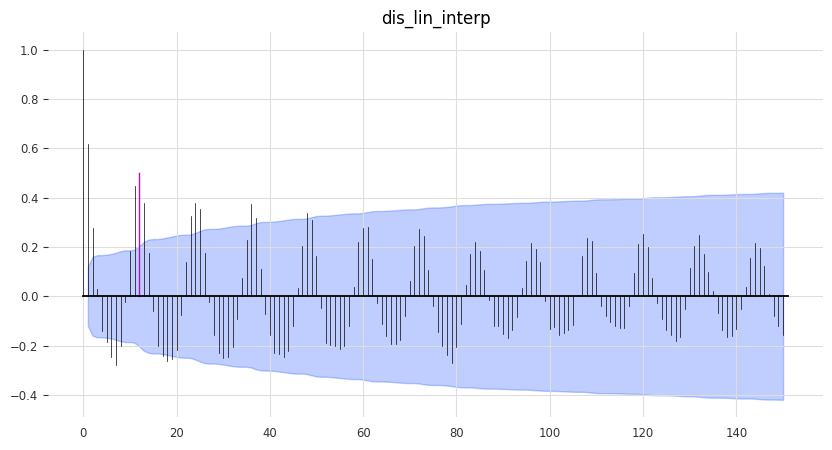

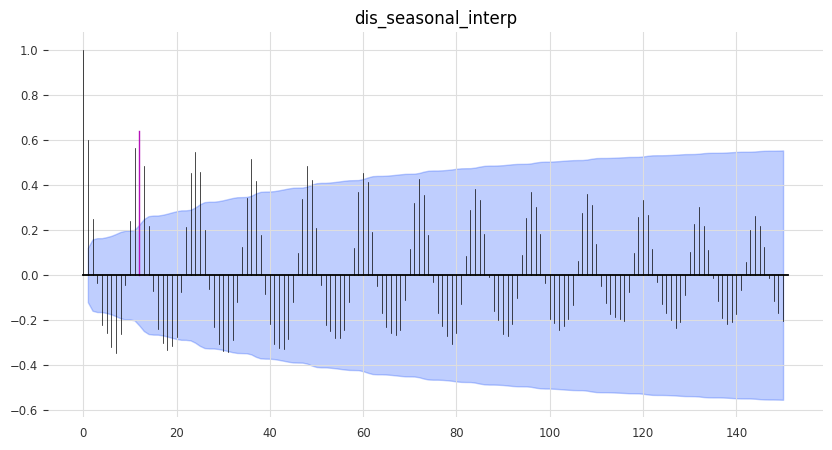

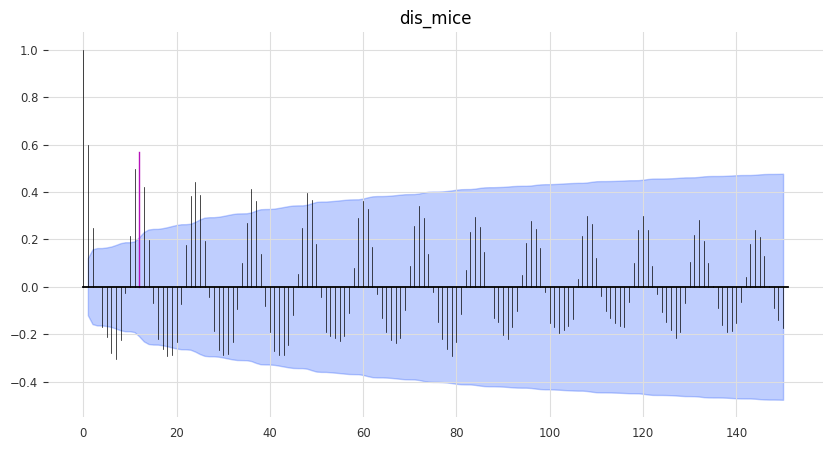

In [38]:
# Create the TimeSeries of each set of data, collecting them in a dict
ts_scaled_dict = {}

for fill_method in fill_methods:
    ts_scaled_dict[fill_method] = TimeSeries.from_dataframe(df, 'month', 'dis'+fill_method)
    plot_acf(ts_scaled_dict[fill_method], periodicity, max_lag=150)
    plt.title('dis'+fill_method)

In [39]:
# Split each data set into training and test sets
ts_split = -36

train_dict={}
test_dict={}

for fill_method in fill_methods :
    train_dict[fill_method] = ts_scaled_dict[fill_method][:ts_split]
    test_dict[fill_method] = ts_scaled_dict[fill_method][ts_split:]


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE = 207.15%


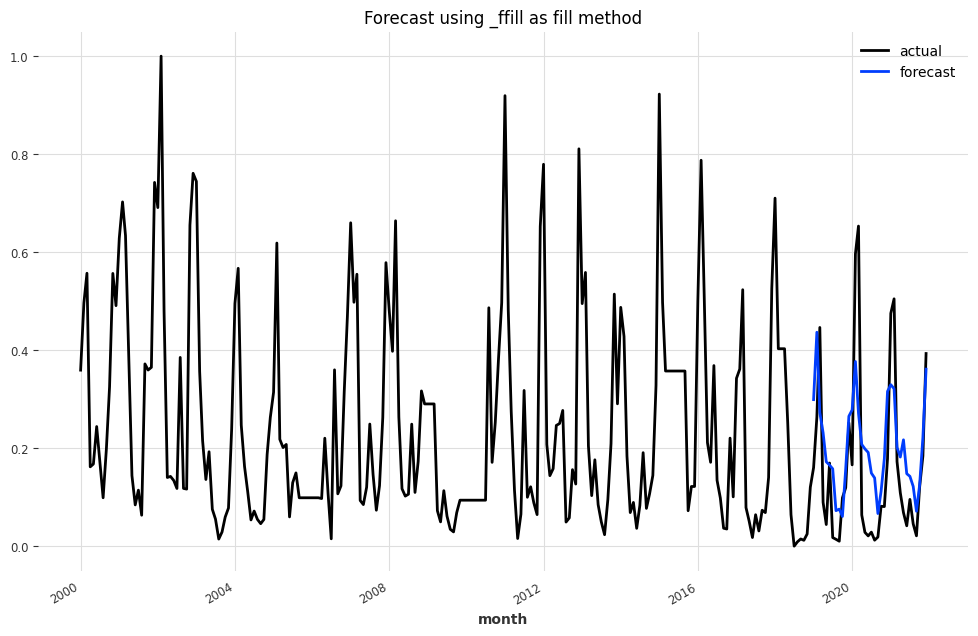

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE = 113.62%


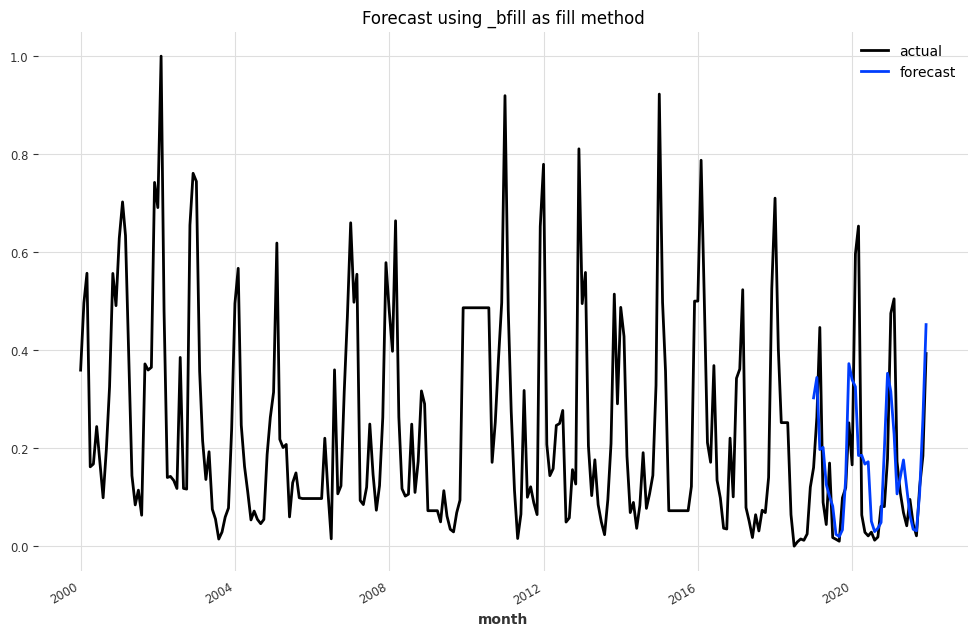

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE = 154.89%


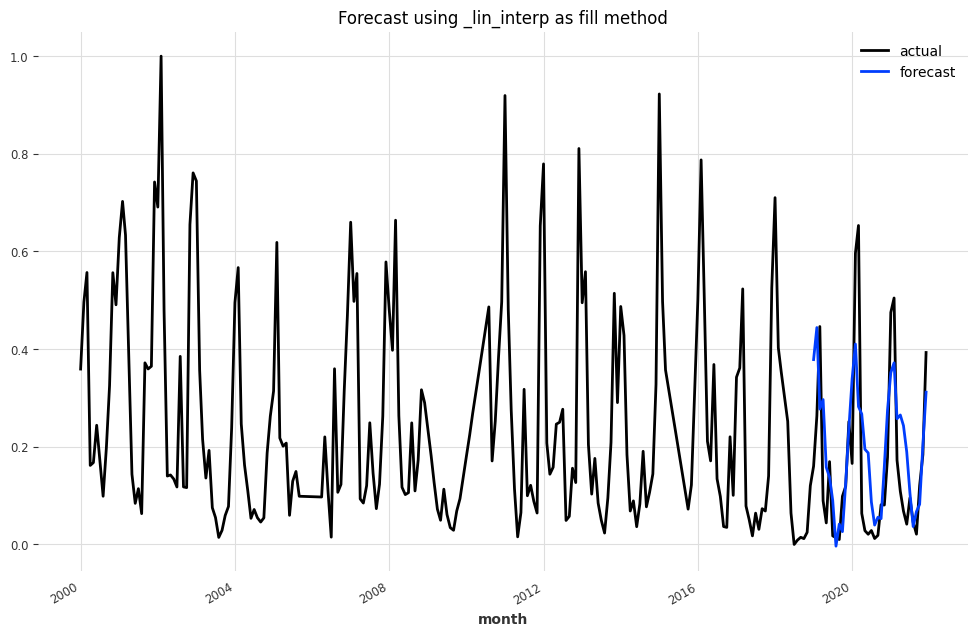

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE = 144.45%


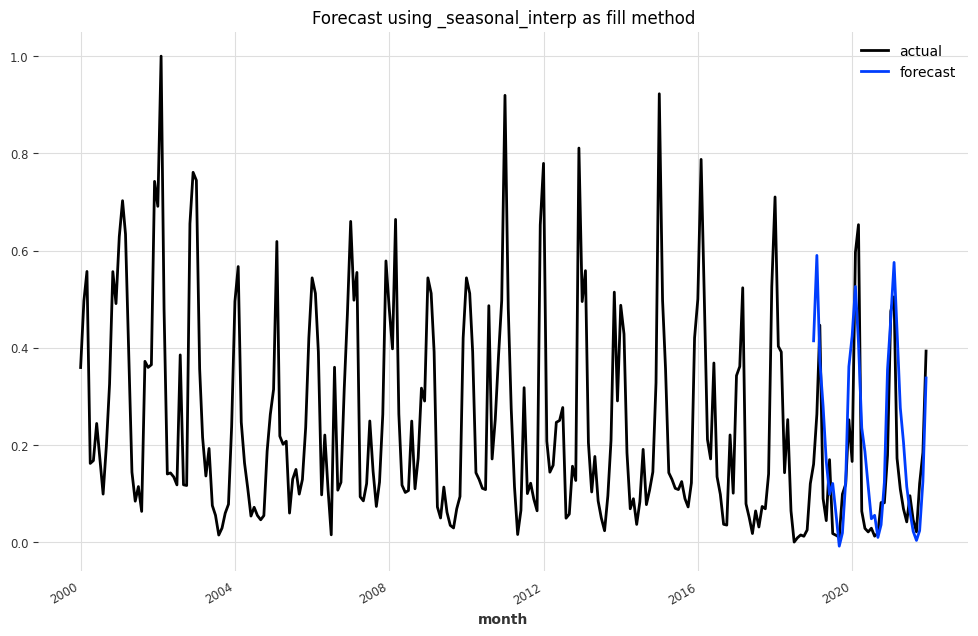

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE = 174.88%


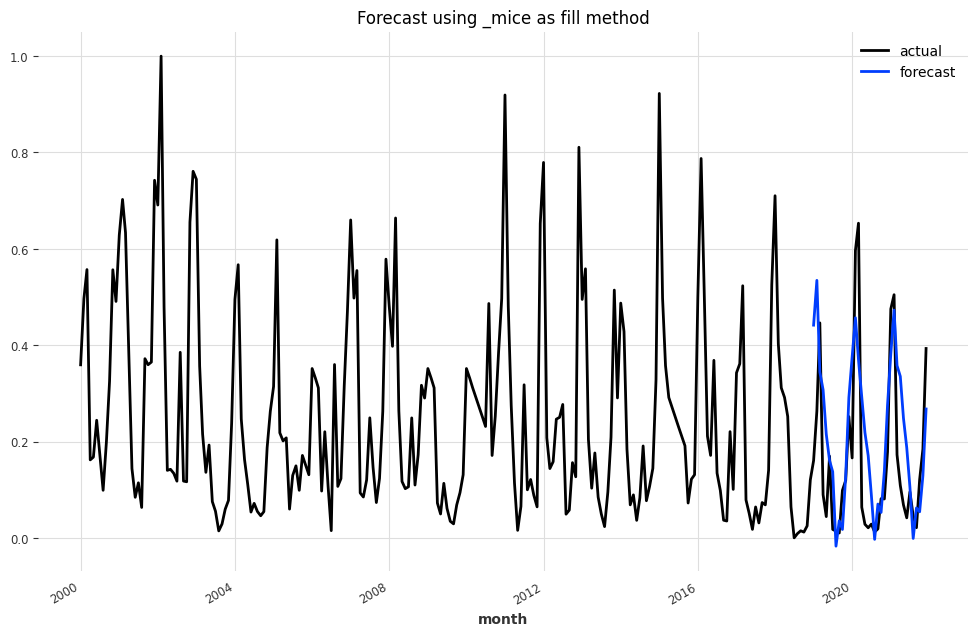

In [40]:
# train the model on each data set to see on which it performs best
for fill_method in fill_methods:    
    model = NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=50,
        random_state=1,
    )

    model.fit(train_dict[fill_method], verbose=True)

    pred = model.predict(n=36)
    ts_scaled_dict[fill_method].plot(label="actual")
    pred.plot(label="forecast")
    plt.legend()
    plt.title('Forecast using ' + fill_method + ' as fill method')
    print("MAPE = {:.2f}%".format(mape(ts_scaled_dict[fill_method], pred)))
    plt.show()
    

The forward-fill and the MICE methods give the best training scores (smaller <code>train_loss</code> values). We keep these two datasets in the following.

# My code to optimize the NBEATS model <a class="anchor" id="NBEATS"></a>

We now turn to the optimization of the NBEATS model by tuning its hyperparameter. As can be checked in the <a href="https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html">documentation</a>, the NBEATS model is a fully connected neural network and we will tune it by playing on the following aspects:
 - a way to stop training when it is completed
 - the number of layers
 - the width, i.e. the number of neurons in each layer
 - the learning rate
 - an eventual regularization
 
Let us first define two useful callbacks from Pytorch Lightning. EarlyStopping stops the training whenever the train loss has not decreased more than 0.002 for 5 epochs, while the LossLogger class stores the train and loss. Suitable learning rate and parameters for the EarlyStopping callback can be found quickly after little hand-tuning, by inspecting the training curve below.

The metric used in the <code>.fit()</code> method of the NBEATSModel is the MEAN Squared Error (MSE). For simplicity and consistance, this is the metric we will work with below, and not the MAPE metric as above.

In [41]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

class StopperTrain(EarlyStopping):
    def __init__(self):
        super().__init__(
        monitor = "train_loss",
        patience = 5,
        min_delta = 0.002,
        mode = 'min'
        )
    
class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))
    
    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


We also define the model configuration to tune. The training is expected to be stopped by the EarlyStopping callback, which is why the number of epochs is set to a high enough number. Above, the batch size was left to its default value of 32, but this makes the training loss to oscillate much more, and is then more difficult to monitor with the EarlyStopping callback. Since the training does not seem to be that slower with only one batch, we set the batch size to the length of the training timeseries (i.e. 228).

In [42]:
def NBEATSToTune(num_layers = None, layer_widths = None, weight_decay = None):
    pl_trainer_kwargs = {'callbacks':[StopperTrain(), LossLogger()]}
    model=NBEATSModel(
        input_chunk_length = 24,
        output_chunk_length = 12,
        n_epochs = 100,
        num_layers = num_layers,
        layer_widths = layer_widths,
        random_state = 1,
        pl_trainer_kwargs = pl_trainer_kwargs,
        optimizer_kwargs = {'lr': 2e-3, 'weight_decay': weight_decay},
        force_reset = True,
        batch_size=228,
        )
    model.loss_logger=pl_trainer_kwargs['callbacks'][1]
    return model


Now we check how is doing the model with the default architecture (4 layers and 256 neurons in each layer). Note that we use for this the metric used for training, which is the mean square error by default in the NBEATSModel class, instead of the MAPE metric used above.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

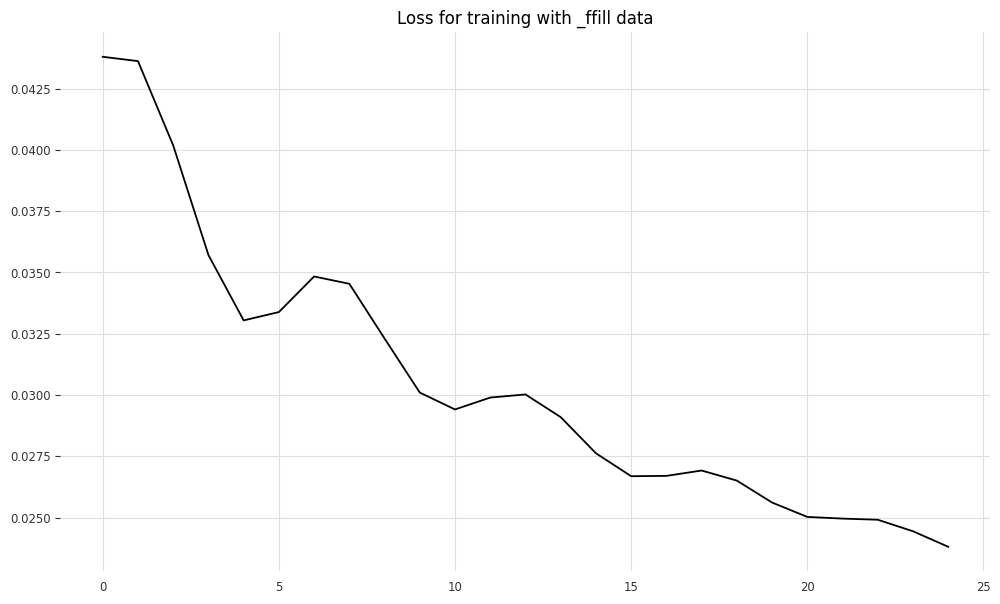

val_loss 0.01897451574866605


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

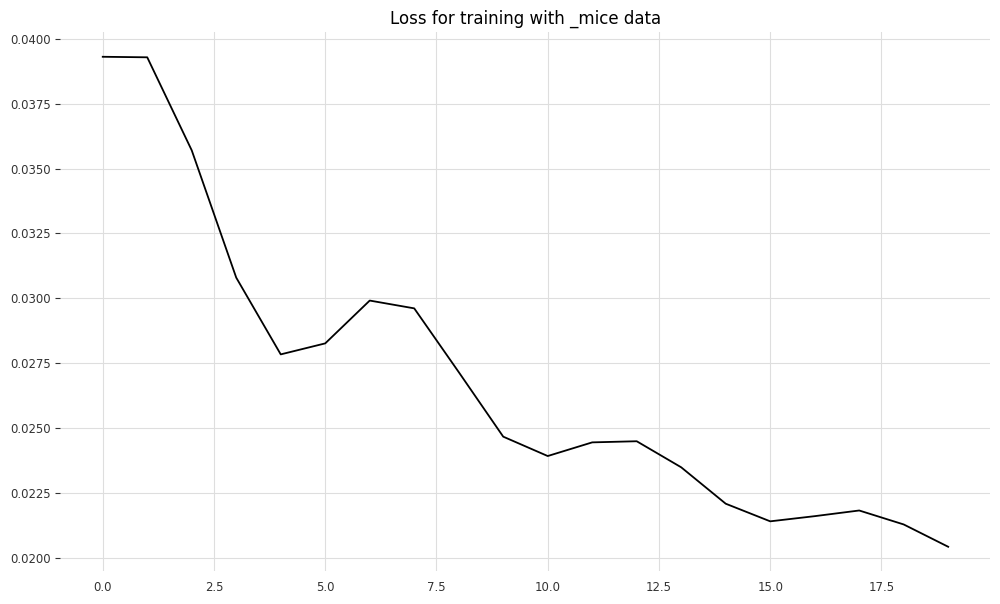

val_loss 0.015507151144283554


In [43]:
for fill_method in ['_ffill', '_mice']:
    
    model = NBEATSToTune(
        num_layers = 4,
        layer_widths = 256,
        weight_decay = 0
        )
    
    model.fit(train_dict[fill_method], val_series = test_dict[fill_method], verbose=True)
    
    # plot loss from epoch 15 (loss decreases very quickly at the beginning)
    plt.plot(model.loss_logger.train_loss[15:])
    plt.title('Loss for training with ' + fill_method +' data')
    plt.show()
    
    # get validation loss at the end of training for future comparison
    print('val_loss', model.loss_logger.val_loss[-1])

This model performs already quite well! This could be expected, since the model is quite big with respect to the data: the widths of the layers is here 256, which is larger than the <code>input_chunk_length = 24</code> and the size of our trainig set of 228.

Since the model performs quite well, we will look for a smaller model with similar performances. The model will hopefully be better suited for the case at hand and be less resources consuming. Define first the model trainer function:

In [44]:
from ray import air, tune
from ray.air import session

def model_trainer(config, train_set=None, test_set=None):
    
    model = NBEATSToTune(
        num_layers = config['num_layers'],
        layer_widths = config['layer_widths'],
        weight_decay = 0
        )


    model.fit(train_set, val_series = test_set, verbose=True)
    
    # report the performance of the trained model to tune
    session.report({'train_loss': model.loss_logger.train_loss[-1],
                    'val_loss': model.loss_logger.val_loss[-1]
                   })


We look for model of 2, 3 or 4 layers with between 64 and 256 neurons in each layer. There is small number of possibilities, so we set <code>tune</code> in grid search mode. The grid search is done for the two filling methods (forward fill and MICE).

In [45]:
search_space = {
    'num_layers' : tune.grid_search([2, 3, 4]),
    'layer_widths' : tune.grid_search([64, 96, 128, 192, 256]),
    }

# dict to store the results
tuner_results_dict={}
 
for fill_method in ['_ffill', '_mice']:
    tuner = tune.Tuner(
        tune.with_parameters(model_trainer,
                             train_set = train_dict[fill_method],
                             test_set = test_dict[fill_method]
                            ),
        param_space=search_space,
        tune_config=tune.TuneConfig(mode='min', metric='train_loss'),
        )

    results = tuner.fit()

    tuner_results_dict[fill_method] = results.get_dataframe()
    

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(model_trainer pid=41105) GPU available: False, used: False
(model_trainer pid=41105) TPU available: False, using: 0 TPU cores
(model_trainer pid=41105) IPU available: False, using: 0 IPUs
(model_trainer pid=41105) HPU available: False, using: 0 HPUs
(model_trainer pid=41105) 
(model_trainer pid=41105)   | Name          | Type             | Params
(model_trainer pid=41105) ---------------------------------------------------
(model_trainer pid=41105) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41105) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41105) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41105) 3 | stacks        | ModuleList       | 198 K 
(model_trainer pid=41105) ---------------------------------------------------
(model_trainer pid=41105) 198 K     Trainable params
(model_trainer pid=41105) 469       Non-trainable params
(model_trainer pid=41105) 198 K     Total params
(model_trainer pid=41105) 0.795     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s, train_loss=2.120]
(model_trainer pid=41105) 
Validation: 0it [00:00, ?it/s]) 
(model_trainer pid=41105) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41105) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s, train_loss=0.753, val_loss=0.804]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s, train_loss=0.143, val_loss=0.154]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s, train_loss=0.211, val_loss=0.109]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s, train_loss=0.386, val_loss=0.232]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s, train_loss=0.318, val_loss=0.203]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, train_loss=0.179, val_loss=0.120]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|████

(model_trainer pid=41251) GPU available: False, used: False
(model_trainer pid=41251) TPU available: False, using: 0 TPU cores
(model_trainer pid=41251) IPU available: False, using: 0 IPUs
(model_trainer pid=41251) HPU available: False, using: 0 HPUs
(model_trainer pid=41251) 
(model_trainer pid=41251)   | Name          | Type             | Params
(model_trainer pid=41251) ---------------------------------------------------
(model_trainer pid=41251) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41251) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41251) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41251) 3 | stacks        | ModuleList       | 386 K 
(model_trainer pid=41251) ---------------------------------------------------
(model_trainer pid=41251) 386 K     Trainable params
(model_trainer pid=41251) 629       Non-trainable params
(model_trainer pid=41251) 386 K     Total params
(model_trainer pid=41251) 1.548     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, train_loss=1.040]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s, train_loss=0.190, val_loss=0.212]
Validation: 0it [00:00, ?it/s]) 
(model_trainer pid=41251) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41251) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s, train_loss=0.190, val_loss=0.216]
                                                                       
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s, train_loss=0.309, val_loss=0.216]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s, train_loss=0.225, val_loss=0.145]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, train_loss=0.0926, val_loss=0.0584]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s, train_loss=0.0626, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]) 
Ep

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s, train_loss=0.0373, val_loss=0.0291]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s, train_loss=0.0354, val_loss=0.0274]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41251) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s, train_loss=0.0354, val_loss=0.0219]
                                                                       
Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s, train_loss=0.0318, val_loss=0.0219]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s, train_loss=0.0318, val_loss=0.0157]


(model_trainer pid=41351) GPU available: False, used: False
(model_trainer pid=41351) TPU available: False, using: 0 TPU cores
(model_trainer pid=41351) IPU available: False, using: 0 IPUs
(model_trainer pid=41351) HPU available: False, using: 0 HPUs
(model_trainer pid=41351) 
(model_trainer pid=41351)   | Name          | Type             | Params
(model_trainer pid=41351) ---------------------------------------------------
(model_trainer pid=41351) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41351) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41351) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41351) 3 | stacks        | ModuleList       | 636 K 
(model_trainer pid=41351) ---------------------------------------------------
(model_trainer pid=41351) 635 K     Trainable params
(model_trainer pid=41351) 789       Non-trainable params
(model_trainer pid=41351) 636 K     Total params
(model_trainer pid=41351) 2.546     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s, train_loss=3.940]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, train_loss=0.941, val_loss=0.976]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, train_loss=0.257, val_loss=0.333]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s, train_loss=0.562, val_loss=0.540]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s, train_loss=0.365, val_loss=0.291]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s, train_loss=0.148, val_loss=0.0704]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41351) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s, train_loss=0.0855, val_loss=0.0313]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s, train_loss=0.1

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss=0.0387, val_loss=0.0409]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s, train_loss=0.0388, val_loss=0.047]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, train_loss=0.038, val_loss=0.0477] 
(model_trainer pid=41351) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41351) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, train_loss=0.0359, val_loss=0.0426]
(model_trainer pid=41351) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41351) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, train_loss=0.0333, val_loss=0.0344]
(model_trainer pid=41351) 
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s, train_loss=0.0315, val_loss=0.0264]
Validation: 0it [00:00,

(model_trainer pid=41470) GPU available: False, used: False
(model_trainer pid=41470) TPU available: False, using: 0 TPU cores
(model_trainer pid=41470) IPU available: False, using: 0 IPUs
(model_trainer pid=41470) HPU available: False, using: 0 HPUs
(model_trainer pid=41470) 
(model_trainer pid=41470)   | Name          | Type             | Params
(model_trainer pid=41470) ---------------------------------------------------
(model_trainer pid=41470) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41470) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41470) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41470) 3 | stacks        | ModuleList       | 1.3 M 
(model_trainer pid=41470) ---------------------------------------------------
(model_trainer pid=41470) 1.3 M     Trainable params
(model_trainer pid=41470) 1.1 K     Non-trainable params
(model_trainer pid=41470) 1.3 M     Total params
(model_trainer pid=41470) 5.280     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, train_loss=2.750]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, train_loss=0.678, val_loss=0.400]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, train_loss=0.415, val_loss=0.168]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, train_loss=0.144, val_loss=0.109]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s, train_loss=0.126, val_loss=0.196]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, train_loss=0.131, val_loss=0.186]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s, train_loss=0.0904, val_loss=0.0911]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, train_loss=0.0688, val_loss=0.0435]
Validation: 0it [00:00, ?it/s]) 
Epoch 8: 100%|██████████| 1/1 [00:00

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s, train_loss=0.0317, val_loss=0.0139]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s, train_loss=0.0303, val_loss=0.014]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s, train_loss=0.0292, val_loss=0.0151]
(model_trainer pid=41470) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41470) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s, train_loss=0.0292, val_loss=0.0171]
                                                                       
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, train_loss=0.0286, val_loss=0.0171]
(model_trainer pid=41470) 
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, train_loss=0.0284, val_loss=0.0201]
(model_trainer pid=41470) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          |

(model_trainer pid=41600) GPU available: False, used: False
(model_trainer pid=41600) TPU available: False, using: 0 TPU cores
(model_trainer pid=41600) IPU available: False, using: 0 IPUs
(model_trainer pid=41600) HPU available: False, using: 0 HPUs
(model_trainer pid=41600) 
(model_trainer pid=41600)   | Name          | Type             | Params
(model_trainer pid=41600) ---------------------------------------------------
(model_trainer pid=41600) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41600) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41600) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41600) 3 | stacks        | ModuleList       | 2.2 M 
(model_trainer pid=41600) ---------------------------------------------------
(model_trainer pid=41600) 2.2 M     Trainable params
(model_trainer pid=41600) 1.4 K     Non-trainable params
(model_trainer pid=41600) 2.2 M     Total params
(model_trainer pid=41600) 8.997     Total estim

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=0.0255, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]) 
Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s, train_loss=0.025, val_loss=0.0147] 
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, train_loss=2.630]
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s, train_loss=0.0243, val_loss=0.0171]
Validation: 0it [00:00, ?it/s]) 
Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s, train_loss=0.0237, val_loss=0.0199]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, train_loss=1.780, val_loss=1.800]
Validation: 0it [00:00, ?it/s]) 
Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, train_loss=0.0235, val_loss=0.0216]
Validation: 0it [00:00, ?it/s]) 
Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s, train_loss=0.0233, val_loss=0.0217]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|████████

Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, train_loss=0.0527, val_loss=0.0647]
Validation: 0it [00:00, ?it/s]) 
Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, train_loss=0.0642, val_loss=0.086]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41600) 
Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, train_loss=0.0642, val_loss=0.0466]
                                                                      
Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, train_loss=0.0387, val_loss=0.0466]
Validation: 0it [00:00, ?it/s]) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, train_loss=0.0341, val_loss=0.0197]
Validation: 0it [00:00, ?it/s]) 
Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s, train_loss=0.0446, val_loss=0.0163]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41600) 
Epoch 15: 100%|██████████| 1/1 [0

(model_trainer pid=41726) GPU available: False, used: False
(model_trainer pid=41726) TPU available: False, using: 0 TPU cores
(model_trainer pid=41726) IPU available: False, using: 0 IPUs
(model_trainer pid=41726) HPU available: False, using: 0 HPUs
(model_trainer pid=41726) 
(model_trainer pid=41726)   | Name          | Type             | Params
(model_trainer pid=41726) ---------------------------------------------------
(model_trainer pid=41726) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41726) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41726) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41726) 3 | stacks        | ModuleList       | 323 K 
(model_trainer pid=41726) ---------------------------------------------------
(model_trainer pid=41726) 323 K     Trainable params
(model_trainer pid=41726) 469       Non-trainable params
(model_trainer pid=41726) 323 K     Total params
(model_trainer pid=41726) 1.294     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s, train_loss=1.860]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, train_loss=0.888, val_loss=0.917]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s, train_loss=0.305, val_loss=0.318]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s, train_loss=0.110, val_loss=0.0853]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41726) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s, train_loss=0.226, val_loss=0.169]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41726) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s, train_loss=0.273, val_loss=0.218]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s, train_loss=0.203, val_loss=0.164]
Validation: 0i

(model_trainer pid=41854) GPU available: False, used: False
(model_trainer pid=41854) TPU available: False, using: 0 TPU cores
(model_trainer pid=41854) IPU available: False, using: 0 IPUs
(model_trainer pid=41854) HPU available: False, using: 0 HPUs
(model_trainer pid=41854) 
(model_trainer pid=41854)   | Name          | Type             | Params
(model_trainer pid=41854) ---------------------------------------------------
(model_trainer pid=41854) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41854) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41854) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41854) 3 | stacks        | ModuleList       | 666 K 
(model_trainer pid=41854) ---------------------------------------------------
(model_trainer pid=41854) 665 K     Trainable params
(model_trainer pid=41854) 629       Non-trainable params
(model_trainer pid=41854) 666 K     Total params
(model_trainer pid=41854) 2.665     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s, train_loss=2.070]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, train_loss=0.422, val_loss=0.268]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s, train_loss=0.146, val_loss=0.182]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s, train_loss=0.431, val_loss=0.540]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s, train_loss=0.251, val_loss=0.329]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss=0.0883, val_loss=0.110]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s, train_loss=0.0634, val_loss=0.0342]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s, train_loss=0.0978, val_loss=0.0341]
Validation: 0it [00:00, ?it/s]) 
Epoch 8: 100%|██████████| 1/1 [00:0

(model_trainer pid=41105) GPU available: False, used: False
(model_trainer pid=41105) TPU available: False, using: 0 TPU cores
(model_trainer pid=41105) IPU available: False, using: 0 IPUs
(model_trainer pid=41105) HPU available: False, using: 0 HPUs


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(model_trainer pid=41854) GPU available: False, used: False
(model_trainer pid=41854) TPU available: False, using: 0 TPU cores
(model_trainer pid=41854) IPU available: False, using: 0 IPUs
(model_trainer pid=41854) HPU available: False, using: 0 HPUs
(model_trainer pid=41854) 
(model_trainer pid=41854)   | Name          | Type             | Params
(model_trainer pid=41854) ---------------------------------------------------
(model_trainer pid=41854) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41854) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41854) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41854) 3 | stacks        | ModuleList       | 2.4 M 
(model_trainer pid=41854) ---------------------------------------------------
(model_trainer pid=41854) 2.4 M     Trainable params
(model_trainer pid=41854) 1.1 K     Non-trainable params
(model_trainer pid=41854) 2.4 M     Total params
(model_trainer pid=41854) 9.727     Total estim

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.12it/s]
                                                                           
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(model_trainer pid=41600) GPU available: False, used: False
(model_trainer pid=41600) TPU available: False, using: 0 TPU cores
(model_trainer pid=41600) IPU available: False, using: 0 IPUs
(model_trainer pid=41600) HPU available: False, using: 0 HPUs
(model_trainer pid=41726) 
(model_trainer pid=41726)   | Name          | Type             | Params
(model_trainer pid=41726) ---------------------------------------------------
(model_trainer pid=41726) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41726) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41726) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41726) 3 | stacks        | ModuleList       | 4.2 M 
(model_trainer pid=41726) ---------------------------------------------------
(model_trainer pid=41726) 4.2 M     Trainable params
(model_trainer pid=41726) 1.4 K     Non-trainable params
(model_trainer pid=41726) 4.2 M     Total params
(model_trainer pid=41726) 16.892    Total estim

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(model_trainer pid=41251) 
(model_trainer pid=41251)   | Name          | Type             | Params
(model_trainer pid=41251) ---------------------------------------------------
(model_trainer pid=41251) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=41251) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=41251) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=41251) 3 | stacks        | ModuleList       | 6.2 M 
(model_trainer pid=41251) ---------------------------------------------------
(model_trainer pid=41251) 6.2 M     Trainable params
(model_trainer pid=41251) 1.4 K     Non-trainable params
(model_trainer pid=41251) 6.2 M     Total params
(model_trainer pid=41251) 24.787    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, train_loss=1.250]
Validation: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             
                                                                           
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, train_loss=3.180]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41351) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, train_loss=0.644, val_loss=0.539]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41105) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=1.480]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s, train_loss=1.820, val_loss=1.920]
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s, train_loss=1.210]
Validation: 0it [00:00, ?it/s]) 


(model_trainer pid=41251) 
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, train_loss=0.339, val_loss=0.285]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, train_loss=0.200, val_loss=0.220] 
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, train_loss=0.182, val_loss=0.172]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, train_loss=0.185, val_loss=0.0933]
Validation: 0it [00:00, ?it/s]) 
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.185, val_loss=0.105]        
(model_trainer pid=41351) 
Validation: 0it [00:00, ?it/s]) 
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.402, val_loss=0.164]        
(model_trainer pid=41600) 
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, train_loss=0.191, val_loss=0.208]
Validation: 0it [00:00, ?it/s]) 
(model_trainer pid=41105) 
Val

Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, train_loss=0.0607, val_loss=0.036]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41854) 
Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, train_loss=0.113, val_loss=0.0893]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, train_loss=0.126, val_loss=0.0916]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, train_loss=0.126, val_loss=0.0411]
                                                                      
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, train_loss=0.0886, val_loss=0.126]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, train_loss=0.366, val_loss=0.229]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, train_loss=0.234, val_loss=0.113]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, train_loss=0.116, val_loss=0.126]
Validation: 0it [00:00, ?it/s]) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s, train_loss=0.0857, val_loss=0.0915]
Validation: 0it [00:00, ?it/s]) 
Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, train_loss=0.0594, val_loss=0.0352]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41957) 
Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, train_loss=0.0594, val_loss=0.0278]
                                                                      
Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, train_loss=0.139, val_loss=0.137]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, train_loss=0.0407, val_loss=0.0241]
Validation: 0it [00:00, ?it/s]) 
Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, train_loss=0.0522, val_loss=0.0278]
Validation: 0it [00:00, ?it/s]) 
Epoc

(model_trainer pid=41957) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, train_loss=0.0678, val_loss=0.0526]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it, train_loss=0.0994, val_loss=0.086]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it, train_loss=0.0994, val_loss=0.061]
                                                                      
Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s, train_loss=0.064, val_loss=0.045] 
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, train_loss=0.111, val_loss=0.128]
Validation: 0it [00:00, ?it/s]) 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, train_loss=0.0627, val_loss=0.0603]
Validation: 0it [00:00, ?it/s]) 
Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, train_loss=0.042, val_loss=0.0299] 
Validation: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, train_loss=0.

Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, train_loss=0.0495, val_loss=0.043]
Validation: 0it [00:00, ?it/s]) 
Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0495, val_loss=0.0339]        
(model_trainer pid=41854) 
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, train_loss=0.0506, val_loss=0.0303]
Validation: 0it [00:00, ?it/s]) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, train_loss=0.0337, val_loss=0.025]
Validation: 0it [00:00, ?it/s]) 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, train_loss=0.0646, val_loss=0.0575]
Validation: 0it [00:00, ?it/s]) 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, train_loss=0.0646, val_loss=0.0525]
                                                                      
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, train_loss=0.0323, val_loss=0.0141]
Validation: 0it [00:00, ?it/s]) 
Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.064

(model_trainer pid=41351) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, train_loss=0.0407, val_loss=0.0268]
Validation: 0it [00:00, ?it/s]) 
Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, train_loss=0.0324, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]) 
Epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, train_loss=0.0619, val_loss=0.0385]
Validation: 0it [00:00, ?it/s]) 
Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, train_loss=0.0472, val_loss=0.0344]
Validation: 0it [00:00, ?it/s]) 
Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0472, val_loss=0.033]        
(model_trainer pid=41726) 
Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0619, val_loss=0.0452]        
(model_trainer pid=41957) 
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, train_loss=0.045, val_loss=0.033] 
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, train_loss=0.045, val_los

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, train_loss=0.0279, val_loss=0.0173]
Validation: 0it [00:00, ?it/s]) 
Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0279, val_loss=0.018]        
(model_trainer pid=41470) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41470) 
Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, train_loss=0.0404, val_loss=0.0294]
Validation: 0it [00:00, ?it/s]) 
Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, train_loss=0.0289, val_loss=0.0187]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, train_loss=0.0751, val_loss=0.0215]
(model_trainer pid=41251) 
Validation: 0it [00:00, ?it/s]) 
Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s, train_loss=0.0406, val_loss=0.0294]
Validation: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, train_loss=0.0432, val_loss=0.0202]
Validation: 0it 

Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, train_loss=0.028, val_loss=0.0172] 
Validation: 0it [00:00, ?it/s]) 
Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, train_loss=0.0289, val_loss=0.0173]
Validation: 0it [00:00, ?it/s]) 
Epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, train_loss=0.0439, val_loss=0.0495]
Validation: 0it [00:00, ?it/s]) 
Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, train_loss=0.0384, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, train_loss=0.0265, val_loss=0.0155]
Validation: 0it [00:00, ?it/s]) 
Epoch 14: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it, train_loss=0.0448, val_loss=0.0334]
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, train_loss=0.0279, val_loss=0.0171]
(model_trainer pid=41470) 
Epoch 14: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, train_loss=0.0448, val_loss=0.0426]
                                       

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, train_loss=0.0244, val_loss=0.0168]
Validation: 0it [00:00, ?it/s]) 
Epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, train_loss=0.0571, val_loss=0.0575]
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, train_loss=0.0238, val_loss=0.0175]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41854) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, train_loss=0.0238, val_loss=0.0189]
                                                                      
(model_trainer pid=41600) 
Validation: 0it [00:00, ?it/s]) 
Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0238, val_loss=0.0189]        
(model_trainer pid=41600) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41600) 
Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, train_loss=0.0377, val_loss=0.0242]
Validation:

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, train_loss=0.0302, val_loss=0.0132]
Validation: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it, train_loss=0.0344, val_loss=0.0189]
Validation: 0it [00:00, ?it/s]) 
Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0344, val_loss=0.0234]        
(model_trainer pid=41470) 
Validation: 0it [00:00, ?it/s]) 
Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, train_loss=0.0291, val_loss=0.0105]
Validation: 0it [00:00, ?it/s]) 
Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, train_loss=0.0418, val_loss=0.00861]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41251) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, train_loss=0.0288, val_loss=0.00943]
Validation: 0it [00:00, ?it/s]) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=0.0402, val_loss=0.0367]
Validation: 0it [00:00, ?it/s]) 
Epoch 

(model_trainer pid=41470) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, train_loss=0.0296, val_loss=0.0251]
Validation: 0it [00:00, ?it/s]) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, train_loss=0.0402, val_loss=0.0193]
Validation: 0it [00:00, ?it/s]) 
(model_trainer pid=41251) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41251) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, train_loss=0.0374, val_loss=0.0215]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=0.0374, val_loss=0.0211]
                                                                      
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, train_loss=0.0288, val_loss=0.0222]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=41726) 
Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, train_loss=0.0357, val_loss=0.0219]
Validation:

Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, train_loss=0.0245, val_loss=0.0232]
Validation: 0it [00:00, ?it/s]) 
Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, train_loss=0.0241, val_loss=0.0236]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, train_loss=0.0323, val_loss=0.024]
(model_trainer pid=41251) 
Validation: 0it [00:00, ?it/s]) 
Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, train_loss=0.0237, val_loss=0.024]
Validation: 0it [00:00, ?it/s]) 
Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, train_loss=0.0233, val_loss=0.0239]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it, train_loss=0.0301, val_loss=0.0197]
Validation: 0it [00:00, ?it/s]) 
Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0301, val_loss=0.0171]        
(model_trainer pid=41726) 
Validation: 0it [00:00, ?it/s]) 
Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s, train_loss=0.0224

Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, train_loss=0.0196, val_loss=0.0277]
Validation: 0it [00:00, ?it/s]) 
Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, train_loss=0.0267, val_loss=0.0171]
Validation: 0it [00:00, ?it/s]) 
Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=0.0191, val_loss=0.0283]
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, train_loss=0.0267, val_loss=0.0172]
Validation: 0it [00:00, ?it/s]) 
Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0267, val_loss=0.0177]        
(model_trainer pid=41726) 
Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, train_loss=0.0269, val_loss=0.0177]
Validation: 0it [00:00, ?it/s]) 
Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=0.0187, val_loss=0.0287]
Validation: 0it [00:00, ?it/s]) 
Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, train_loss=0.0265, val_loss=0.0175]
Validation: 0it [00:00, ?it/s]) 
Epoch 

Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, train_loss=0.0151, val_loss=0.0354]
Validation: 0it [00:00, ?it/s]) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, train_loss=0.0238, val_loss=0.0187]
Validation: 0it [00:00, ?it/s]) 
Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, train_loss=0.0151, val_loss=0.0214]
Validation: 0it [00:00, ?it/s]) 
Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, train_loss=0.0139, val_loss=0.0311]
Validation: 0it [00:00, ?it/s]) 
Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, train_loss=0.0131, val_loss=0.0279]
Validation: 0it [00:00, ?it/s]) 
Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, train_loss=0.0133, val_loss=0.021]
(model_trainer pid=41726) 
Validation: 0it [00:00, ?it/s]) 
Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, train_loss=0.0125, val_loss=0.0306]
Validation: 0it [00:00, ?it/s]) 
Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s, train_loss=0.0118, val_loss=0.0278]
Validat

(model_trainer pid=42944) GPU available: False, used: False
(model_trainer pid=42944) TPU available: False, using: 0 TPU cores
(model_trainer pid=42944) IPU available: False, using: 0 IPUs
(model_trainer pid=42944) HPU available: False, using: 0 HPUs
(model_trainer pid=42944) 
(model_trainer pid=42944)   | Name          | Type             | Params
(model_trainer pid=42944) ---------------------------------------------------
(model_trainer pid=42944) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=42944) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=42944) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=42944) 3 | stacks        | ModuleList       | 198 K 
(model_trainer pid=42944) ---------------------------------------------------
(model_trainer pid=42944) 198 K     Trainable params
(model_trainer pid=42944) 469       Non-trainable params
(model_trainer pid=42944) 198 K     Total params
(model_trainer pid=42944) 0.795     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss=2.130]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s, train_loss=0.757, val_loss=0.803]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, train_loss=0.142, val_loss=0.154]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=42944) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, train_loss=0.209, val_loss=0.111]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, train_loss=0.385, val_loss=0.237]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, train_loss=0.317, val_loss=0.208]
(model_trainer pid=42944) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=42944) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s, train_loss=0.176, val_

(model_trainer pid=43082) GPU available: False, used: False
(model_trainer pid=43082) TPU available: False, using: 0 TPU cores
(model_trainer pid=43082) IPU available: False, using: 0 IPUs
(model_trainer pid=43082) HPU available: False, using: 0 HPUs
(model_trainer pid=43082) 
(model_trainer pid=43082)   | Name          | Type             | Params
(model_trainer pid=43082) ---------------------------------------------------
(model_trainer pid=43082) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43082) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43082) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43082) 3 | stacks        | ModuleList       | 386 K 
(model_trainer pid=43082) ---------------------------------------------------
(model_trainer pid=43082) 386 K     Trainable params
(model_trainer pid=43082) 629       Non-trainable params
(model_trainer pid=43082) 386 K     Total params
(model_trainer pid=43082) 1.548     Total estim

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.74it/s]
                                                                           
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, train_loss=1.040]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s, train_loss=0.189, val_loss=0.209]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s, train_loss=0.304, val_loss=0.212]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s, train_loss=0.222, val_loss=0.147]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s, train_loss=0.0888, val_loss=0.0596]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, train_loss=0.0589, val_loss=0.0547]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, train_loss=0.0856, val_loss=0.0889]
Validation: 0it [00:00, ?it/s]) 
Epoc

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, train_loss=0.0324, val_loss=0.0261]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s, train_loss=0.0308, val_loss=0.0243]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, train_loss=0.0272, val_loss=0.0192]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s, train_loss=0.0272, val_loss=0.0135]


(model_trainer pid=43183) GPU available: False, used: False
(model_trainer pid=43183) TPU available: False, using: 0 TPU cores
(model_trainer pid=43183) IPU available: False, using: 0 IPUs
(model_trainer pid=43183) HPU available: False, using: 0 HPUs
(model_trainer pid=43183) 
(model_trainer pid=43183)   | Name          | Type             | Params
(model_trainer pid=43183) ---------------------------------------------------
(model_trainer pid=43183) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43183) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43183) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43183) 3 | stacks        | ModuleList       | 636 K 
(model_trainer pid=43183) ---------------------------------------------------
(model_trainer pid=43183) 635 K     Trainable params
(model_trainer pid=43183) 789       Non-trainable params
(model_trainer pid=43183) 636 K     Total params
(model_trainer pid=43183) 2.546     Total estim

Sanity Checking: 0it [00:00, ?it/s] 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, train_loss=3.940]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s, train_loss=0.936, val_loss=0.981]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, train_loss=0.252, val_loss=0.327]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s, train_loss=0.557, val_loss=0.526]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s, train_loss=0.360, val_loss=0.281]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, train_loss=0.143, val_loss=0.0657]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s, train_loss=0.0818, val_loss=0.0337]
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s, train_loss=0.0989, val_loss=0.0875]
Validation: 0it [00:00, ?it/s])

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, train_loss=0.0336, val_loss=0.039]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, train_loss=0.0337, val_loss=0.0433]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, train_loss=0.0328, val_loss=0.0435]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, train_loss=0.0308, val_loss=0.0387]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, train_loss=0.0284, val_loss=0.0313]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, train_loss=0.0265, val_loss=0.0237]
Validation: 0it [00:00, ?it/s]) 
Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s, train_loss=0.0258, val_loss=0.0185]
Validation: 0it [00:00, ?it/s]) 
Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s, train_loss=0.026, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]) 
E

(model_trainer pid=43297) GPU available: False, used: False
(model_trainer pid=43297) TPU available: False, using: 0 TPU cores
(model_trainer pid=43297) IPU available: False, using: 0 IPUs
(model_trainer pid=43297) HPU available: False, using: 0 HPUs
(model_trainer pid=43297) 
(model_trainer pid=43297)   | Name          | Type             | Params
(model_trainer pid=43297) ---------------------------------------------------
(model_trainer pid=43297) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43297) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43297) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43297) 3 | stacks        | ModuleList       | 1.3 M 
(model_trainer pid=43297) ---------------------------------------------------
(model_trainer pid=43297) 1.3 M     Trainable params
(model_trainer pid=43297) 1.1 K     Non-trainable params
(model_trainer pid=43297) 1.3 M     Total params
(model_trainer pid=43297) 5.280     Total estim

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, train_loss=2.740]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, train_loss=0.682, val_loss=0.395]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, train_loss=0.412, val_loss=0.166]
(model_trainer pid=43297) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43297) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, train_loss=0.140, val_loss=0.110]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43297) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, train_loss=0.140, val_loss=0.198]
                                                                       
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s, train_loss=0.123, val_loss=0.198]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<0

Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, train_loss=0.028, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, train_loss=0.027, val_loss=0.0162]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, train_loss=0.0253, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s, train_loss=0.024, val_loss=0.0152] 
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, train_loss=0.0235, val_loss=0.0161]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s, train_loss=0.0236, val_loss=0.0188]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, train_loss=0.0234, val_loss=0.0222]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, train_loss=0.0234, val_loss=0.0234]
                                  

(model_trainer pid=43428) GPU available: False, used: False
(model_trainer pid=43428) TPU available: False, using: 0 TPU cores
(model_trainer pid=43428) IPU available: False, using: 0 IPUs
(model_trainer pid=43428) HPU available: False, using: 0 HPUs
(model_trainer pid=43428) 
(model_trainer pid=43428)   | Name          | Type             | Params
(model_trainer pid=43428) ---------------------------------------------------
(model_trainer pid=43428) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43428) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43428) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43428) 3 | stacks        | ModuleList       | 2.2 M 
(model_trainer pid=43428) ---------------------------------------------------
(model_trainer pid=43428) 2.2 M     Trainable params
(model_trainer pid=43428) 1.4 K     Non-trainable params
(model_trainer pid=43428) 2.2 M     Total params
(model_trainer pid=43428) 8.997     Total estim

(model_trainer pid=43297) 
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, train_loss=0.0196, val_loss=0.0152]
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, train_loss=2.630]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, train_loss=1.780, val_loss=1.810]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s, train_loss=0.124, val_loss=0.0976]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s, train_loss=0.202, val_loss=0.116]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s, train_loss=0.0769, val_loss=0.0707]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, train_loss=0.195, val_loss=0.238] 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43428) 
Epoch

Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, train_loss=0.023, val_loss=0.0275] 
Validation: 0it [00:00, ?it/s]) 
Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, train_loss=0.0284, val_loss=0.0458]
Validation: 0it [00:00, ?it/s]) 
Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0284, val_loss=0.0534]        


(model_trainer pid=43554) GPU available: False, used: False
(model_trainer pid=43554) TPU available: False, using: 0 TPU cores
(model_trainer pid=43554) IPU available: False, using: 0 IPUs
(model_trainer pid=43554) HPU available: False, using: 0 HPUs
(model_trainer pid=43554) 
(model_trainer pid=43554)   | Name          | Type             | Params
(model_trainer pid=43554) ---------------------------------------------------
(model_trainer pid=43554) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43554) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43554) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43554) 3 | stacks        | ModuleList       | 323 K 
(model_trainer pid=43554) ---------------------------------------------------
(model_trainer pid=43554) 323 K     Trainable params
(model_trainer pid=43554) 469       Non-trainable params
(model_trainer pid=43554) 323 K     Total params
(model_trainer pid=43554) 1.294     Total estim

Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, train_loss=0.0327, val_loss=0.0534]
(model_trainer pid=43428) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43428) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, train_loss=1.870]
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s, train_loss=1.870, val_loss=0.918]
                                                                      
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, train_loss=0.888, val_loss=0.918]
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s, train_loss=0.303, val_loss=0.320]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, train_loss=0.0277, val_loss=0.0426]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s, train_loss=0.107, val_loss=0.085]
Validation: 0it [00:00, ?it/s]) 
E

(model_trainer pid=43674) GPU available: False, used: False
(model_trainer pid=43674) TPU available: False, using: 0 TPU cores
(model_trainer pid=43674) IPU available: False, using: 0 IPUs
(model_trainer pid=43674) HPU available: False, using: 0 HPUs
(model_trainer pid=43674) 
(model_trainer pid=43674)   | Name          | Type             | Params
(model_trainer pid=43674) ---------------------------------------------------
(model_trainer pid=43674) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43674) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43674) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43674) 3 | stacks        | ModuleList       | 666 K 
(model_trainer pid=43674) ---------------------------------------------------
(model_trainer pid=43674) 665 K     Trainable params
(model_trainer pid=43674) 629       Non-trainable params
(model_trainer pid=43674) 666 K     Total params
(model_trainer pid=43674) 2.665     Total estim

Sanity Checking: 0it [00:00, ?it/s] 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss=2.080]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s, train_loss=0.426, val_loss=0.264]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43674) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s, train_loss=0.139, val_loss=0.177]
Validation: 0it [00:00, ?it/s]) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, train_loss=0.434, val_loss=0.548]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, train_loss=0.255, val_loss=0.336]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43674) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s, train_loss=0.0868, val_loss=0.109]
Validation: 0it [00:00, ?it/s]) 
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s, train_loss=

(model_trainer pid=43554) GPU available: False, used: False
(model_trainer pid=43554) TPU available: False, using: 0 TPU cores
(model_trainer pid=43554) IPU available: False, using: 0 IPUs
(model_trainer pid=43554) HPU available: False, using: 0 HPUs
(model_trainer pid=43785) GPU available: False, used: False
(model_trainer pid=43785) TPU available: False, using: 0 TPU cores
(model_trainer pid=43785) IPU available: False, using: 0 IPUs
(model_trainer pid=43785) HPU available: False, using: 0 HPUs
(model_trainer pid=43785) 
(model_trainer pid=43785)   | Name          | Type             | Params
(model_trainer pid=43785) ---------------------------------------------------
(model_trainer pid=43785) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43785) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43785) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43785) 3 | stacks        | ModuleList       | 1.1 M 
(model_trainer pid=43785) -------

Sanity Checking: 0it [00:00, ?it/s]


(model_trainer pid=42944) GPU available: False, used: False
(model_trainer pid=42944) TPU available: False, using: 0 TPU cores
(model_trainer pid=42944) IPU available: False, using: 0 IPUs
(model_trainer pid=42944) HPU available: False, using: 0 HPUs
(model_trainer pid=43183) GPU available: False, used: False
(model_trainer pid=43183) TPU available: False, using: 0 TPU cores
(model_trainer pid=43183) IPU available: False, using: 0 IPUs
(model_trainer pid=43183) HPU available: False, using: 0 HPUs
(model_trainer pid=43428) GPU available: False, used: False
(model_trainer pid=43428) TPU available: False, using: 0 TPU cores
(model_trainer pid=43428) IPU available: False, using: 0 IPUs
(model_trainer pid=43428) HPU available: False, using: 0 HPUs
(model_trainer pid=43554) 
(model_trainer pid=43554)   | Name          | Type             | Params
(model_trainer pid=43554) ---------------------------------------------------
(model_trainer pid=43554) 0 | criterion     | MSELoss          | 0    

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(model_trainer pid=43183) 
(model_trainer pid=43183)   | Name          | Type             | Params
(model_trainer pid=43183) ---------------------------------------------------
(model_trainer pid=43183) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43183) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43183) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43183) 3 | stacks        | ModuleList       | 945 K 
(model_trainer pid=43183) ---------------------------------------------------
(model_trainer pid=43183) 945 K     Trainable params
(model_trainer pid=43183) 629       Non-trainable params
(model_trainer pid=43183) 945 K     Total params
(model_trainer pid=43183) 3.783     Total estimated model params size (MB)
(model_trainer pid=43297) GPU available: False, used: False
(model_trainer pid=43297) TPU available: False, using: 0 TPU cores
(model_trainer pid=43297) IPU available: False, using: 0 IPUs
(model_trainer pid=43297) HPU avai

                                                                           
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(model_trainer pid=42944) 
(model_trainer pid=42944)   | Name          | Type             | Params
(model_trainer pid=42944) ---------------------------------------------------
(model_trainer pid=42944) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=42944) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=42944) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=42944) 3 | stacks        | ModuleList       | 448 K 
(model_trainer pid=42944) ---------------------------------------------------
(model_trainer pid=42944) 447 K     Trainable params
(model_trainer pid=42944) 469       Non-trainable params
(model_trainer pid=42944) 448 K     Total params
(model_trainer pid=42944) 1.794     Total estimated model params size (MB)
(model_trainer pid=43082) GPU available: False, used: False
(model_trainer pid=43082) TPU available: False, using: 0 TPU cores
(model_trainer pid=43082) IPU available: False, using: 0 IPUs
(model_trainer pid=43082) HPU avai

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(model_trainer pid=43082) 
(model_trainer pid=43082)   | Name          | Type             | Params
(model_trainer pid=43082) ---------------------------------------------------
(model_trainer pid=43082) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43082) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43082) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43082) 3 | stacks        | ModuleList       | 3.5 M 
(model_trainer pid=43082) ---------------------------------------------------
(model_trainer pid=43082) 3.5 M     Trainable params
(model_trainer pid=43082) 1.1 K     Non-trainable params
(model_trainer pid=43082) 3.5 M     Total params
(model_trainer pid=43082) 14.174    Total estimated model params size (MB)
(model_trainer pid=43674) GPU available: False, used: False
(model_trainer pid=43674) TPU available: False, using: 0 TPU cores
(model_trainer pid=43674) IPU available: False, using: 0 IPUs
(model_trainer pid=43674) HPU avai

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, train_loss=1.470]
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, train_loss=1.250]
Validation: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(model_trainer pid=43674) 
(model_trainer pid=43674)   | Name          | Type             | Params
(model_trainer pid=43674) ---------------------------------------------------
(model_trainer pid=43674) 0 | criterion     | MSELoss          | 0     
(model_trainer pid=43674) 1 | train_metrics | MetricCollection | 0     
(model_trainer pid=43674) 2 | val_metrics   | MetricCollection | 0     
(model_trainer pid=43674) 3 | stacks        | ModuleList       | 6.2 M 
(model_trainer pid=43674) ---------------------------------------------------
(model_trainer pid=43674) 6.2 M     Trainable params
(model_trainer pid=43674) 1.4 K     Non-trainable params
(model_trainer pid=43674) 6.2 M     Total params
(model_trainer pid=43674) 24.787    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, train_loss=3.180]
Validation: 0it [00:00, ?it/s]) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, train_loss=1.210]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, train_loss=0.222, val_loss=0.240]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43785) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s, train_loss=0.222, val_loss=0.127]
                                                                      
(model_trainer pid=43554) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, train_loss=1.210, val_loss=0.0908]
                                                                      
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s, train_loss=0.642, val_loss=0.540]
(model_trainer pid=42944) 
Validation: 0it [00:00, ?it/s]) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s, train_loss=0.256, val_lo

Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, train_loss=1.520]
Validation: 0it [00:00, ?it/s]) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s, train_loss=0.337, val_loss=0.283]
(model_trainer pid=43183) 
Validation: 0it [00:00, ?it/s]) 
Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, train_loss=0.127, val_loss=0.139]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it, train_loss=0.871, val_loss=0.968]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it, train_loss=0.871, val_loss=0.188]
                                                                      
(model_trainer pid=43183) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, train_loss=0.055, val_loss=0.0507]
Validation: 0it [00:00, ?it/s]) 
Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, train_loss=0.0729, val_loss=0.0772]
Validation: 0it [00:00, ?it/s]) 
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, train_loss=0

Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, train_loss=0.0708, val_loss=0.0425]
Validation: 0it [00:00, ?it/s]) 
Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, train_loss=0.233, val_loss=0.116]
(model_trainer pid=43183) 
Validation: 0it [00:00, ?it/s]) 
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43183) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43554) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.26it/s]
(model_trainer pid=43674) 
Validation: 0it [00:00, ?it/s]) 
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0708, val_loss=0.0332]        
(model_trainer pid=43183) 
Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.111, val_loss=0.112]        
(model_trainer pid=43674) 
Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, train_loss=0.233, val_loss=0.577]
(model_trainer pid=43674) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, train_loss=0.365, val_lo

(model_trainer pid=43082) 
Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, train_loss=0.563, val_loss=0.577]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43674) 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, train_loss=0.0604, val_loss=0.0616]
(model_trainer pid=43297) 
Validation: 0it [00:00, ?it/s]) 
Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s, train_loss=0.0428, val_loss=0.0268]
Validation: 0it [00:00, ?it/s]) 
Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, train_loss=0.098, val_loss=0.111]
Validation: 0it [00:00, ?it/s]) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, train_loss=0.0403, val_loss=0.0288]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43785) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s, train_loss=0.0403, val_loss=0.0322]
                                                       

Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, train_loss=0.0681, val_loss=0.0689]
Validation: 0it [00:00, ?it/s]) 
Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, train_loss=0.0369, val_loss=0.028]
Validation: 0it [00:00, ?it/s]) 
Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0369, val_loss=0.0205]        
(model_trainer pid=43674) 
Validation: 0it [00:00, ?it/s]) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s, train_loss=0.0332, val_loss=0.0309]
(model_trainer pid=43785) 
Validation: 0it [00:00, ?it/s]) 
Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, train_loss=0.0775, val_loss=0.0863]
Validation: 0it [00:00, ?it/s]) 
Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, train_loss=0.0396, val_loss=0.0318]
Validation: 0it [00:00, ?it/s]) 
Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, train_loss=0.0306, val_loss=0.028]
Validation: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, train_loss=0.0672,

(model_trainer pid=43082) 
Validation: 0it [00:00, ?it/s]) 
Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, train_loss=0.0276, val_loss=0.0132]
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, train_loss=0.0519, val_loss=0.0304]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, train_loss=0.0275, val_loss=0.0227]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s, train_loss=0.0492, val_loss=0.0282]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s, train_loss=0.026, val_loss=0.0218] 
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, train_loss=0.026, val_loss=0.0203]
                                                                      
Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, train_loss=0.0393, val_loss=0.0194]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1

Epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, train_loss=0.0435, val_loss=0.0498]
Validation: 0it [00:00, ?it/s]) 
Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, train_loss=0.047, val_loss=0.0351] 
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, train_loss=0.0242, val_loss=0.0174]
Validation: 0it [00:00, ?it/s]) 
Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, train_loss=0.0456, val_loss=0.0357]
Validation: 0it [00:00, ?it/s]) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, train_loss=0.0363, val_loss=0.0147]
Validation: 0it [00:00, ?it/s]) 
Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0363, val_loss=0.0127]        
(model_trainer pid=43183) 
Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, train_loss=0.0456, val_loss=0.0352]
                                                                      
Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, train_loss=0.0242, val_loss=0.017]
Va

Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, train_loss=0.0378, val_loss=0.031]
(model_trainer pid=43183) 
Validation: 0it [00:00, ?it/s]) 
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, train_loss=0.0283, val_loss=0.0141]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43297) 
Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, train_loss=0.0452, val_loss=0.0442]
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s, train_loss=0.037, val_loss=0.030] 
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, train_loss=0.037, val_loss=0.0292]
                                                                      
(model_trainer pid=43428) 
Validation: 0it [00:00, ?it/s]) 
Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0364, val_loss=0.0322]        
(model_trainer pid=43082) 
Epoch 15: 100%|██████████| 1/1 [00:00<00:00,

Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, train_loss=0.0328, val_loss=0.0246]
Validation: 0it [00:00, ?it/s]) 
Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, train_loss=0.0259, val_loss=0.0149]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43183) 
Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0328, val_loss=0.0232]        
(model_trainer pid=43297) 
Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, train_loss=0.0259, val_loss=0.0123]
                                                                      
Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, train_loss=0.0239, val_loss=0.0165]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43183) 
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43183) 
Epoch 38: 100%|██████████| 1/1 [00:00<00

Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, train_loss=0.0282, val_loss=0.020]
Validation: 0it [00:00, ?it/s]) 
Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s, train_loss=0.0241, val_loss=0.0134]
(model_trainer pid=43297) 
Validation: 0it [00:00, ?it/s]) 
Epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it, train_loss=0.0414, val_loss=0.0439]
(model_trainer pid=43297) 
Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0241, val_loss=0.0137]        
(model_trainer pid=43082) 
Validation: 0it [00:00, ?it/s]) 
Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, train_loss=0.0274, val_loss=0.020]
Validation: 0it [00:00, ?it/s]) 
Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s, train_loss=0.0233, val_loss=0.0137]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, train_loss=0.0213, val_loss=0.013]
Validation: 0it [00:00, ?it/s]) 
Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, train_loss=0.0265, val_l

Epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, train_loss=0.0285, val_loss=0.0193]
Validation: 0it [00:00, ?it/s]) 
Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, train_loss=0.0212, val_loss=0.0121]
Validation: 0it [00:00, ?it/s]) 
Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, train_loss=0.0432, val_loss=0.0312]
Validation: 0it [00:00, ?it/s]) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, train_loss=0.0278, val_loss=0.0256]
Validation: 0it [00:00, ?it/s]) 
Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, train_loss=0.0309, val_loss=0.0238]
Validation: 0it [00:00, ?it/s]) 
Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=0.0309, val_loss=0.0212]        
(model_trainer pid=43428) 
Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, train_loss=0.0214, val_loss=0.0124]
Validation: 0it [00:00, ?it/s]) 
Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, train_loss=0.0206, val_loss=0.0125]
Validation: 0it [00:00, ?it/s]) 
Epoch 

Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, train_loss=0.0269, val_loss=0.0226]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, train_loss=0.0238, val_loss=0.0208]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43428) 
Epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it, train_loss=0.0393, val_loss=0.0163]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43674) 
Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, train_loss=0.0254, val_loss=0.0242]
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, train_loss=0.0249, val_loss=0.0248]
Validation: 0it [00:00, ?it/s]) 
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, train_loss=0.0232, val_loss=0.0184]
Validation: 0it [00:00, ?it/s]) 
Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, train_loss=0.0

Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, train_loss=0.0215, val_loss=0.0222]
Validation: 0it [00:00, ?it/s]) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, train_loss=0.0296, val_loss=0.0285]
Validation: 0it [00:00, ?it/s]) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(model_trainer pid=43674) 
Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, train_loss=0.0296, val_loss=0.0249]
                                                                      
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, train_loss=0.0211, val_loss=0.0231]
Validation: 0it [00:00, ?it/s]) 
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, train_loss=0.0211, val_loss=0.0223]
                                                                      
Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, train_loss=0.0272, val_loss=0.0249]
Validation: 0it [00:00, ?it/s]) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, train_loss=0.0207, val_loss=

Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, train_loss=0.0213, val_loss=0.0167]
Validation: 0it [00:00, ?it/s]) 
Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, train_loss=0.0204, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]) 
Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, train_loss=0.0204, val_loss=0.0155]


We now extract the configurations for which the train loss was below 0.03.

In [46]:
for fill_method in ['_ffill', '_mice']:
    print(fill_method)
    print(tuner_results_dict[fill_method][tuner_results_dict[fill_method].train_loss<0.03]
          [['train_loss', 'val_loss', 'config/layer_widths', 'config/num_layers']])

_ffill
    train_loss  val_loss  config/layer_widths  config/num_layers
2     0.027374  0.025484                  128                  2
3     0.021989  0.018774                  192                  2
4     0.027232  0.018360                  256                  2
7     0.027882  0.017085                  128                  3
8     0.022634  0.020056                  192                  3
9     0.011250  0.025429                  256                  3
12    0.028918  0.012256                  128                  4
14    0.023812  0.018975                  256                  4
_mice
    train_loss  val_loss  config/layer_widths  config/num_layers
1     0.027208  0.013531                   96                  2
2     0.022745  0.021484                  128                  2
3     0.019635  0.017740                  192                  2
4     0.022715  0.016633                  256                  2
7     0.022244  0.016410                  128                  3
8     0.0196

The smallest architectures performing well enough (train loss below 0.03) in both cases is thus that with 2 layers of 128 neurons each. Since the model generalizes well to the test data (<code>val_loss</code> values are close to the <code>train loss</code> values), there is no need for a regularization here.

The network found is thus 4 times smaller (2 $\times$ 128 vs. 4 $\times$ 256) than the original one, with similar performances !

Note that the architecture 192 $\times$ 2 has yet better scores, roughly equal to ones of the original 4 $\times$ 256. While the latter had a little bit of overfitting, there is almost none in the former, since the validation scores are very close to the training scores.